In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans


In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans

def read_json_file(file_path):
    dataframes = []
    with open(file_path, 'r') as file:
        for line in file:
            json_obj = json.loads(line.strip())
            if 'data' in json_obj and 'name' in json_obj:
                df = pd.DataFrame(json_obj['data'], columns=['Date', json_obj['name']])
                df['Date'] = pd.to_datetime(df['Date'], format='%Y%m', errors='coerce')
                df = df.dropna().set_index('Date')
                dataframes.append(df)
            else:
                print(f"Warning: Skipping a line due to missing 'data' or 'name' key.")
    return pd.concat(dataframes, axis=1)

# Usage
file_path = '/content/drive/MyDrive/fp2/TOTAL Energy.txt'
data = read_json_file(file_path)
data = data.iloc[:607, :]
data.replace('NA', np.nan, inplace=True)

# Drop columns with more than a set threshold of missing values
threshold_for_dropping = 10  # 10% of missing values in the data
data = data.drop(columns=data.columns[data.isnull().mean() * 100 > threshold_for_dropping])

# Function to count non-numeric values in object columns
def count_non_numeric_values(df):
    object_columns = df.select_dtypes(include=['object'])
    non_numeric_values_count = {}
    for col in object_columns.columns:
        col_as_string = object_columns[col].astype(str)
        unique_non_numeric = col_as_string.str.extractall(r'([a-zA-Z]+)')[0].unique()
        counts = {val: col_as_string.str.count(val).sum() for val in unique_non_numeric}
        non_numeric_values_count[col] = counts
    return non_numeric_values_count

# Count non-numeric values
non_numeric_values_count = count_non_numeric_values(data)

# Identifying and encoding 'W' values
w_columns = [col for col, counts in non_numeric_values_count.items() if 'W' in counts]
w_data = data[w_columns]
w_encoded_data = w_data.apply(lambda col: col.map(lambda x: 1 if x == 'W' else 0))

# Clustering for 'W' values
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(w_encoded_data)
cluster_labels = kmeans.predict(w_encoded_data)
cluster_centers = kmeans.cluster_centers_

# Encoding 'W' values based on clusters
modified_data = data.copy()
for col in w_data.columns:
    for cluster_id in range(n_clusters):
        cluster_mean = cluster_centers[cluster_id][w_data.columns.get_loc(col)]
        mask = (modified_data[col] == 'W') & (cluster_labels == cluster_id)
        modified_data.loc[mask, col] = cluster_mean

# Backfilling 'nan' and 'NM' values
columns_to_backfill = [col for col, counts in non_numeric_values_count.items() if 'nan' in counts or 'NM' in counts]
modified_data[columns_to_backfill] = modified_data[columns_to_backfill].fillna(method='bfill', axis=0)
modified_data[columns_to_backfill] = modified_data[columns_to_backfill].replace('NM', method='ffill')

# Final data
data = modified_data


In [ ]:
data

Distillate Fuel Oil, Excluding Biodiesel, CO2 Emissions, Monthly  \
Date                                                                           
1973-01-01                                             55.157                  
1973-02-01                                             51.771                  
1973-03-01                                             44.460                  
1973-04-01                                             33.973                  
1973-05-01                                             35.591                  
...                                                       ...                  
2023-03-01                                             53.548                  
2023-04-01                                             49.292                  
2023-05-01                                             51.256                  
2023-06-01                                             49.915                  
2023-07-01                                             47.656                  

            Total Fossil Fuels Consumed by the Industrial Sector, Monthly  \
Date                                                                        
1973-01-01                                           1924.933               
1973-02-01                                           1749.012               
1973-03-01                                           1824.239               
1973-04-01                                           1815.181               
1973-05-01                                           1974.342               
...                                                       ...               
2023-03-01                                           1704.510               
2023-04-01                                           1659.460               
2023-05-01                                           1682.041               
2023-06-01                                           1635.721               
2023-07-01                                           1656.706               

            Residential Share of Electric Power Sector CO2 Emissions, Monthly  \
Date                                                                            
1973-01-01                                             40.771                   
1973-02-01                                             35.238                   
1973-03-01                                             33.477                   
1973-04-01                                             29.694                   
1973-05-01                                             29.728                   
...                                                       ...                   
2023-03-01                                             38.063                   
2023-04-01                                             31.358                   
2023-05-01                                             34.774                   
2023-06-01                                             47.426                   
2023-07-01                                             67.828                   

            Distillate Fuel Oil Imports, Monthly  \
Date                                               
1973-01-01                               364.161   
1973-02-01                               731.214   
1973-03-01                               602.323   
1973-04-01                               240.233   
1973-05-01                               267.774   
...                                          ...   
2023-03-01                               155.258   
2023-04-01                               155.667   
2023-05-01                               168.194   
2023-06-01                               138.033   
2023-07-01                               119.516   

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            727.361                
1973

In [ ]:
column_list = data.columns.tolist()
print(column_list)

['Distillate Fuel Oil, Excluding Biodiesel, CO2 Emissions, Monthly', 'Total Fossil Fuels Consumed by the Industrial Sector, Monthly', 'Residential Share of Electric Power Sector CO2 Emissions, Monthly', 'Distillate Fuel Oil Imports, Monthly', 'Distillate Fuel Oil Consumed by the Industrial Sector, Monthly', 'Electricity Imports, Monthly', 'Distillate Fuel Oil Consumption for Electricity Generation, Electric Power Sector, Monthly', 'Wells Drilled, Dry, Monthly', 'Coal, Including Coal Coke Net Imports, CO2 Emissions, Monthly', 'Natural Gas Net Imports, Monthly', 'Natural Gas Imports, Monthly', 'Electricity Net Generation From Wood, All Sectors, Monthly', 'Natural Gas Imports from Nigeria, Monthly', 'Natural Gas Imports from Algeria, Monthly', 'Cooling Degree-Days, West North Central, Monthly', 'Cooling Degree-Days, Pacific, Monthly', 'Cooling Degree-Days, United States, Monthly', 'Natural Gas Consumed by the Industrial Sector, Total, Monthly', 'Kerosene Consumed by the Residential Sector

In [ ]:
# # Categories and their associated keywords
# categories = {
#     'Price Dynamics': ['Price', 'Cost', 'Average Free on Board', 'Average Landed Cost'],
#     'Energy Types': ['Natural Gas', 'Coal', 'Petroleum', 'Nuclear', 'Renewable'],
#     'Energy Demand': ['Consumed', 'Sales to Ultimate Customers', 'Demand'],
#     'Energy Supply': ['Production', 'Net Generation', 'Supply'],
#     'Other Costs': ['Losses', 'Unaccounted'],
#     'Energy Production': ['Production', 'Generation', 'Field Production'],
#     'Energy Consumption': ['Consumed', 'Usage'],
#     'Trade': ['Imports', 'Exports', 'Trade'],
#     'Annual Data': ['Annual'],
#     'Energy Categories': ['Renewable', 'Non-Renewable', 'Natural']
# }

# # Creating empty dictionaries for datasets
# datasets = {category: [] for category in categories}

# # Categorizing columns into datasets
# for col in column_list:
#     for category, keywords in categories.items():
#         if any(keyword in col for keyword in keywords):
#             datasets[category].append(col)

# # Creating separate dataframes for each category
# category_dataframes = {category: pd.DataFrame() for category in datasets}

# # Dropping categorized columns from the original dataframe
# for category, cols in datasets.items():
#     existing_cols = [col for col in cols if col in data.columns]
#     category_dataframes[category] = data[existing_cols]
#     data.drop(columns=existing_cols, inplace=True)


In [ ]:
# energy_types = category_dataframes['Energy Types']
# energy_demand = category_dataframes['Energy Demand']
# energy_supply = category_dataframes['Energy Supply']
# energy_production = category_dataframes['Energy Production']
# energy_consumption = category_dataframes['Energy Consumption']
# trade = category_dataframes['Trade']
# annual_data = category_dataframes['Annual Data']

In [ ]:
columns_to_drop = [col for col in data.columns if ('import' in col.lower() or 'export' in col.lower()) and col not in ['total_import', 'total_export']]
data = data.drop(columns=columns_to_drop)
data

Distillate Fuel Oil, Excluding Biodiesel, CO2 Emissions, Monthly  \
Date                                                                           
1973-01-01                                             55.157                  
1973-02-01                                             51.771                  
1973-03-01                                             44.460                  
1973-04-01                                             33.973                  
1973-05-01                                             35.591                  
...                                                       ...                  
2023-03-01                                             53.548                  
2023-04-01                                             49.292                  
2023-05-01                                             51.256                  
2023-06-01                                             49.915                  
2023-07-01                                             47.656                  

            Total Fossil Fuels Consumed by the Industrial Sector, Monthly  \
Date                                                                        
1973-01-01                                           1924.933               
1973-02-01                                           1749.012               
1973-03-01                                           1824.239               
1973-04-01                                           1815.181               
1973-05-01                                           1974.342               
...                                                       ...               
2023-03-01                                           1704.510               
2023-04-01                                           1659.460               
2023-05-01                                           1682.041               
2023-06-01                                           1635.721               
2023-07-01                                           1656.706               

            Residential Share of Electric Power Sector CO2 Emissions, Monthly  \
Date                                                                            
1973-01-01                                             40.771                   
1973-02-01                                             35.238                   
1973-03-01                                             33.477                   
1973-04-01                                             29.694                   
1973-05-01                                             29.728                   
...                                                       ...                   
2023-03-01                                             38.063                   
2023-04-01                                             31.358                   
2023-05-01                                             34.774                   
2023-06-01                                             47.426                   
2023-07-01                                             67.828                   

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            727.361                
1973-02-01                                            874.019                
1973-03-01                                            718.377                
1973-04-01                                            530.107                
1973-05-01                                            678.634                
...                                                       ...                
2023-03-01                                            624.555                
2023-04-01                                            511.594                
2023-05-01                                            515.915                
2023-06-01                                            492

In [ ]:
threshold = 0.2
max_zeros = int(threshold * len(data))
data = data.loc[:, (data == 0).sum() < max_zeros]
data

Distillate Fuel Oil, Excluding Biodiesel, CO2 Emissions, Monthly  \
Date                                                                           
1973-01-01                                             55.157                  
1973-02-01                                             51.771                  
1973-03-01                                             44.460                  
1973-04-01                                             33.973                  
1973-05-01                                             35.591                  
...                                                       ...                  
2023-03-01                                             53.548                  
2023-04-01                                             49.292                  
2023-05-01                                             51.256                  
2023-06-01                                             49.915                  
2023-07-01                                             47.656                  

            Total Fossil Fuels Consumed by the Industrial Sector, Monthly  \
Date                                                                        
1973-01-01                                           1924.933               
1973-02-01                                           1749.012               
1973-03-01                                           1824.239               
1973-04-01                                           1815.181               
1973-05-01                                           1974.342               
...                                                       ...               
2023-03-01                                           1704.510               
2023-04-01                                           1659.460               
2023-05-01                                           1682.041               
2023-06-01                                           1635.721               
2023-07-01                                           1656.706               

            Residential Share of Electric Power Sector CO2 Emissions, Monthly  \
Date                                                                            
1973-01-01                                             40.771                   
1973-02-01                                             35.238                   
1973-03-01                                             33.477                   
1973-04-01                                             29.694                   
1973-05-01                                             29.728                   
...                                                       ...                   
2023-03-01                                             38.063                   
2023-04-01                                             31.358                   
2023-05-01                                             34.774                   
2023-06-01                                             47.426                   
2023-07-01                                             67.828                   

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            727.361                
1973-02-01                                            874.019                
1973-03-01                                            718.377                
1973-04-01                                            530.107                
1973-05-01                                            678.634                
...                                                       ...                
2023-03-01                                            624.555                
2023-04-01                                            511.594                
2023-05-01                                            515.915                
2023-06-01                                            492

In [ ]:
production_keywords = [
    "Production", "Generated", "Generation", "Produced", "Supplied",
    "Field Production", "Net Generation", "Refinery", "Net Input",
    "Extraction", "Drilled", "Plant Liquids Production",
    "Blender Net Production", "Net Production", "Field",
    "Drilling"
]
consumption_keywords = [
    "Consumption", "Consumed", "Use", "Usage",
    "Expenditure", "Sales", "Purchases", "End Use", "Losses",
    "Withdrawals", "Utilization", "Demand",
]

# Filtering columns based on keywords
production_columns = [col for col in data.columns if any(keyword in col for keyword in production_keywords)]
consumption_columns = [col for col in data.columns if any(keyword in col for keyword in consumption_keywords)]

# Creating separate dataframes
production_df = data[production_columns]
consumption_df = data[consumption_columns]

In [ ]:
production_df

Distillate Fuel Oil Consumption for Electricity Generation, Electric Power Sector, Monthly  \
Date                                                                                                     
1973-01-01                                           5607.498                                            
1973-02-01                                           4877.895                                            
1973-03-01                                           2774.787                                            
1973-04-01                                           2418.350                                            
1973-05-01                                           2249.309                                            
...                                                       ...                                            
2023-03-01                                            756.917                                            
2023-04-01                                            703.829                                            
2023-05-01                                            796.877                                            
2023-06-01                                            727.325                                            
2023-07-01                                            667.911                                            

            Wells Drilled, Dry, Monthly  \
Date                                      
1973-01-01                        868.0   
1973-02-01                        747.0   
1973-03-01                        811.0   
1973-04-01                        658.0   
1973-05-01                        809.0   
...                                 ...   
2023-03-01                        217.0   
2023-04-01                        216.0   
2023-05-01                        209.0   
2023-06-01                        198.0   
2023-07-01                        194.0   

            Electricity Net Generation From Wood, All Sectors, Monthly  \
Date                                                                     
1973-01-01                                              5.157            
1973-02-01                                             15.138            
1973-03-01                                             17.940            
1973-04-01                                              6.323            
1973-05-01                                              4.589            
...                                                       ...            
2023-03-01                                           2692.253            
2023-04-01                                           2343.861            
2023-05-01                                           2809.916            
2023-06-01                                           2650.080            
2023-07-01                                           2810.599            

            Geothermal Energy Consumption/Production, Monthly  \
Date                                                            
1973-01-01                                              0.490   
1973-02-01                                              0.448   
1973-03-01                                              0.464   
1973-04-01                                              0.542   
1973-05-01                                              0.505   
...                                                       ...   
2023-03-01                                             10.065   
2023-04-01                                              9.906   
2023-05-01                                             10.060   
2023-06-01                                              9.549   
2023-07-01                                              9.941   

            Nuclear Electric Power Consumption/Production, Monthly  \
Date                                                                 
1973-01-01                                             68.103        
1973-02-01                                            

In [ ]:
consumption_df

Total Fossil Fuels Consumed by the Industrial Sector, Monthly  \
Date                                                                        
1973-01-01                                           1924.933               
1973-02-01                                           1749.012               
1973-03-01                                           1824.239               
1973-04-01                                           1815.181               
1973-05-01                                           1974.342               
...                                                       ...               
2023-03-01                                           1704.510               
2023-04-01                                           1659.460               
2023-05-01                                           1682.041               
2023-06-01                                           1635.721               
2023-07-01                                           1656.706               

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            727.361                
1973-02-01                                            874.019                
1973-03-01                                            718.377                
1973-04-01                                            530.107                
1973-05-01                                            678.634                
...                                                       ...                
2023-03-01                                            624.555                
2023-04-01                                            511.594                
2023-05-01                                            515.915                
2023-06-01                                            492.116                
2023-07-01                                            337.826                

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            131.343                
1973-02-01                                            142.552                
1973-03-01                                            129.721                
1973-04-01                                             92.636                
1973-05-01                                            122.544                
...                                                       ...                
2023-03-01                                            111.714                
2023-04-01                                             88.557                
2023-05-01                                             92.282                
2023-06-01                                             85.185                
2023-07-01                                             60.427                

            Distillate Fuel Oil Consumption for Electricity Generation, Electric Power Sector, Monthly  \
Date                                                                                                     
1973-01-01                                           5607.498                                            
1973-02-01                                           4877.895                                            
1973-03-01                                           2774.787                                            
1973-04-01                                           2418.350                                            
1973-05-01                                           2249.309                                            
...                                                       ...                                            
2023-03-01                                            756.917                                            
2023-04-01                

In [ ]:
# production_df.to_csv('production_df.csv', index=True)

In [ ]:
# consumption_df.to_csv('consumption_df.csv', index=True)

In [ ]:
production_df.describe()

Distillate Fuel Oil Consumption for Electricity Generation, Electric Power Sector, Monthly  \
count                                         607.000000                                            
mean                                         1683.646369                                            
std                                          1285.152610                                            
min                                           461.919000                                            
25%                                           885.135000                                            
50%                                          1197.357000                                            
75%                                          1952.111500                                            
max                                          9517.835000                                            

       Wells Drilled, Dry, Monthly  \
count                   607.000000   
mean                    696.163097   
std                     613.727166   
min                      43.000000   
25%                     298.000000   
50%                     412.000000   
75%                     954.500000   
max                    2736.000000   

       Electricity Net Generation From Wood, All Sectors, Monthly  \
count                                         607.000000            
mean                                         2138.913328            
std                                          1483.809545            
min                                             0.195000            
25%                                            45.275500            
50%                                          2951.334000            
75%                                          3271.411500            
max                                          4725.823000            

       Geothermal Energy Consumption/Production, Monthly  \
count                                         607.000000   
mean                                            5.693778   
std                                             3.248265   
min                                             0.448000   
25%                                             2.644000   
50%                                             5.838000   
75%                                             9.210000   
max                                            10.736000   

       Nuclear Electric Power Consumption/Production, Monthly  \
count                                         607.000000        
mean                                          521.617099        
std                                           202.207211        
min                                            62.111000        
25%                                           331.471000        
50%                                           600.110000        
75%                                           681.503000        
max                                           780.456000        

       Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
count                                         607.000000                                        
mean                                        49620.252534                                        
std                                         19680.215914                                        
min                                          5696.657000                                        
25%                                         31123.189500                                        
50%                                         57205.864000                                        
75%                                         65135.235000                                        
max                                         74649.040000                                        

       Distillate Fuel Oil Consumption for Electricity Generation, All Sectors, Monthly  \
count                                   

In [ ]:
# analysing production_df
numerical_columns = production_df.select_dtypes(include=['number'])
categorical_columns = production_df.select_dtypes(include=['object'])
categorical_columns

Total Petroleum Consumption for Electricity Generation, Electric Power Sector, Monthly  \
Date                                                                                                
1973-01-01                                            56011.2                                       
1973-02-01                                           47171.46                                       
1973-03-01                                          42838.179                                       
1973-04-01                                          36061.029                                       
1973-05-01                                          38360.363                                       
...                                                       ...                                       
2023-03-01                                           2211.146                                       
2023-04-01                                           2211.146                                       
2023-05-01                                           2212.306                                       
2023-06-01                                           2193.586                                       
2023-07-01                                           2718.548                                       

           Electricity Net Generation From Petroleum, Electric Power Sector, Monthly  \
Date                                                                                   
1973-01-01                                          31183.619                          
1973-02-01                                          26086.952                          
1973-03-01                                          24033.245                          
1973-04-01                                          20195.424                          
1973-05-01                                          21741.975                          
...                                                       ...                          
2023-03-01                                           1358.398                          
2023-04-01                                           1145.886                          
2023-05-01                                           1099.207                          
2023-06-01                                           1151.062                          
2023-07-01                                            1452.56                          

           Petroleum Coke Consumption for Electricity Generation and Useful Thermal Output, Electric Power Sector, Monthly  \
Date                                                                                                                         
1973-01-01                                              41.67                                                                
1973-02-01                                             34.472                                                                
1973-03-01                                             27.042                                                                
1973-04-01                                             42.319                                                                
1973-05-01                                             54.444                                                                
...                                                       ...                                                                
2023-03-01                                            136.302                                                                
2023-04-01                                            136.302                                                                
2023-05-01                                            130.416                                                                
2023-06-01                                            143.335                                                                
2023-07-01                              

In [ ]:
categorical_columns.nunique()

Total Petroleum Consumption for Electricity Generation, Electric Power Sector, Monthly                              605
Electricity Net Generation From Petroleum, Electric Power Sector, Monthly                                           606
Petroleum Coke Consumption for Electricity Generation and Useful Thermal Output, Electric Power Sector, Monthly     605
Petroleum Coke Consumption for Electricity Generation, Electric Power Sector, Monthly                               605
Total Petroleum Consumption for Electricity Generation and Useful Thermal Output, Electric Power Sector, Monthly    605
dtype: int64

In [ ]:
# Find columns containing the word "consumption"
consumption_columns = [col for col in production_df.columns if 'consumption' in col.lower()]

# Print the list of columns containing "consumption"
print(consumption_columns)


['Distillate Fuel Oil Consumption for Electricity Generation, Electric Power Sector, Monthly', 'Geothermal Energy Consumption/Production, Monthly', 'Nuclear Electric Power Consumption/Production, Monthly', 'Distillate Fuel Oil Consumption for Electricity Generation, All Sectors, Monthly', 'Distillate Fuel Oil Consumption for Electricity Generation and Useful Thermal Output, Electric Power Sector, Monthly', 'Total Petroleum Consumption for Electricity Generation, Electric Power Sector, Monthly', 'Petroleum Products Supplied/Consumption, United States, Monthly', 'Wood Consumption for Electricity Generation and Useful Thermal Output, Electric Power Sector, Monthly', 'Natural Gas Consumption for Electricity Generation and Useful Thermal Output, Electric Power Sector, Monthly', 'Distillate Fuel Oil Consumption for Electricity Generation and Useful Thermal Output, All Sectors, Monthly', 'Total Petroleum Consumption for Electricity Generation and Useful Thermal Output, All Sectors, Monthly', 

In [ ]:
# Find columns containing the word "consumption"
consumption_columns = [col for col in production_df.columns if 'consumption' in col.lower()]

# Drop the identified columns
production_df = production_df.drop(columns=consumption_columns)


In [ ]:
numerical_columns = production_df.select_dtypes(include=['number'])
categorical_columns = production_df.select_dtypes(include=['object'])
categorical_columns

Electricity Net Generation From Petroleum, Electric Power Sector, Monthly
Date                                                                                
1973-01-01                                          31183.619                       
1973-02-01                                          26086.952                       
1973-03-01                                          24033.245                       
1973-04-01                                          20195.424                       
1973-05-01                                          21741.975                       
...                                                       ...                       
2023-03-01                                           1358.398                       
2023-04-01                                           1145.886                       
2023-05-01                                           1099.207                       
2023-06-01                                           1151.062                       
2023-07-01                                            1452.56                       

[607 rows x 1 columns]

In [ ]:
column_names = production_df.columns.tolist()
for col in column_names:
    print(col)

Wells Drilled, Dry, Monthly
Electricity Net Generation From Wood, All Sectors, Monthly
Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly
Electricity Net Generation From Geothermal, Electric Power Sector, Monthly
Distillate Fuel Oil Product Supplied, Monthly
Distillate Fuel Oil Product Supplied, Monthly
Distillate Fuel Oil Product Supplied, Monthly
Distillate Fuel Oil Product Supplied, Monthly
Distillate Fuel Oil Refinery and Blender Net Production, Monthly
Natural Gas Plant Liquids Production, Monthly
Wells Drilled, Natural Gas, Monthly
Crude Oil, Natural Gas, and Dry Wells, Vertical Trajectory, Total Footage Drilled, Monthly
Crude Oil Wells, Total Footage Drilled , Monthly
Crude Oil, Natural Gas, and Dry Wells Drilled, Vertical Trajectory, Monthly
Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly
Lubricants Product Supplied, Monthly
Lubricants Product Supplied, Monthly
Crude Oil Refinery and Blender Net Input, Monthly
Elec

In [ ]:
production_df["Electricity Net Generation From Petroleum, Electric Power Sector, Monthly"] = pd.to_numeric(production_df["Electricity Net Generation From Petroleum, Electric Power Sector, Monthly"], errors='coerce')

In [ ]:
production_df.describe().T

count          mean  \
Wells Drilled, Dry, Monthly                         607.0    696.163097   
Electricity Net Generation From Wood, All Secto...  607.0   2138.913328   
Electricity Net Generation From Nuclear Electri...  607.0  49620.252534   
Electricity Net Generation From Geothermal, Ele...  607.0   1015.754107   
Distillate Fuel Oil Product Supplied, Monthly       607.0   3481.827934   
...                                                   ...           ...   
Natural Gas Marketed Production (Wet), Monthly      607.0   1876.144308   
Kerosene Product Supplied, Monthly                  607.0     70.626231   
Kerosene Product Supplied, Monthly                  607.0     12.160766   
Electricity Net Generation From Hydroelectric P...  607.0    243.912071   
Total Fossil Fuels Production, Monthly              607.0   5063.124717   

                                                             std       min  \
Wells Drilled, Dry, Monthly                           613.727166    43.000   
Electricity Net Generation From Wood, All Secto...   1483.809545     0.195   
Electricity Net Generation From Nuclear Electri...  19680.215914  5696.657   
Electricity Net Generation From Geothermal, Ele...    404.588603   131.171   
Distillate Fuel Oil Product Supplied, Monthly         584.448181  2057.613   
...                                                          ...       ...   
Natural Gas Marketed Production (Wet), Monthly        498.351172  1284.803   
Kerosene Product Supplied, Monthly                     71.206803   -16.285   
Kerosene Product Supplied, Monthly                     12.224492    -2.800   
Electricity Net Generation From Hydroelectric P...    116.010640    52.460   
Total Fossil Fuels Production, Monthly                653.977447  3676.065   

                                                           25%        50%  \
Wells Drilled, Dry, Monthly                           298.0000    412.000   
Electricity Net Generation From Wood, All Secto...     45.2755   2951.334   
Electricity Net Generation From Nuclear Electri...  31123.1895  57205.864   
Electricity Net Generation From Geothermal, Ele...    765.0695   1221.079   
Distillate Fuel Oil Product Supplied, Monthly        2980.6485   3605.516   
...                                                        ...        ...   
Natural Gas Marketed Production (Wet), Monthly       1593.1585   1678.109   
Kerosene Product Supplied, Monthly                     13.6205     50.194   
Kerosene Product Supplied, Monthly                      2.3650      8.702   
Electricity Net Generation From Hydroelectric P...    158.7105    239.887   
Total Fossil Fuels Production, Monthly               4685.8005   4840.115   

                                                           75%        max  
Wells Drilled, Dry, Monthly                           954.5000   2736.000  
Electricity Net Generation From Wood, All Secto...   3271.4115   4725.823  
Electricity Net Generation From Nuclear Electri...  65135.2350  74649.040  
Electricity Net Generation From Geothermal, Ele...   1303.9560   1744.081  
Distillate Fuel Oil Product Supplied, Monthly        3945.1960   5103.194  
...                                                        ...        ...  
Natural Gas Marketed Production (Wet), Monthly       1950.3660   3509.475  
Kerosene Product Supplied, Monthly                    108.5945    405.968  
Kerosene Product Supplied, Monthly                     18.7945     71.357  
Electricity Net Generation From Hydroelectric P...    296.7980    600.081  
Total Fossil Fuels Production, Monthly               5128.7495   7334.834  

[126 rows x 8 columns]

In [ ]:
net_columns = [col for col in production_df.columns if 'Net' in col]

# Create a new DataFrame with only the selected columns
net_df = production_df[net_columns]

In [ ]:
# Filter columns containing the word "month"
month_columns = [col for col in net_df.columns if 'month' in col.lower()]
month_columns

['Electricity Net Generation From Wood, All Sectors, Monthly',
 'Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly',
 'Electricity Net Generation From Geothermal, Electric Power Sector, Monthly',
 'Distillate Fuel Oil Refinery and Blender Net Production, Monthly',
 'Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly',
 'Crude Oil Refinery and Blender Net Input, Monthly',
 'Electricity Net Generation From Conventional Hydroelectric Power, Electric Power Sector, Monthly',
 'Electricity Net Generation Total (including from sources not shown), Electric Power Sector, Monthly',
 'Electricity Net Generation Total (including from sources not shown), Industrial Sector, Monthly',
 'Other Liquids Refinery and Blender Net Inputs, Monthly',
 'Electricity Net Generation From Petroleum, Electric Power Sector, Monthly',
 'Total Hydrocarbon Gas Liquids Refinery and Blender Net Production, Monthly',
 'Propane/Propylene Refinery and Blender Ne

In [ ]:
# Create a new DataFrame with only the selected columns
month_production_df = net_df[month_columns]
month_production_df

Electricity Net Generation From Wood, All Sectors, Monthly  \
Date                                                                     
1973-01-01                                              5.157            
1973-02-01                                             15.138            
1973-03-01                                             17.940            
1973-04-01                                              6.323            
1973-05-01                                              4.589            
...                                                       ...            
2023-03-01                                           2692.253            
2023-04-01                                           2343.861            
2023-05-01                                           2809.916            
2023-06-01                                           2650.080            
2023-07-01                                           2810.599            

            Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
Date                                                                                                 
1973-01-01                                           6246.251                                        
1973-02-01                                           5928.069                                        
1973-03-01                                           6649.007                                        
1973-04-01                                           5876.392                                        
1973-05-01                                           5696.657                                        
...                                                       ...                                        
2023-03-01                                          62820.443                                        
2023-04-01                                          56501.105                                        
2023-05-01                                          61472.883                                        
2023-06-01                                          64965.076                                        
2023-07-01                                          69887.588                                        

            Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
Date                                                                                     
1973-01-01                                            143.490                            
1973-02-01                                            131.171                            
1973-03-01                                            135.938                            
1973-04-01                                            158.705                            
1973-05-01                                            147.965                            
...                                                       ...                            
2023-03-01                                           1317.427                            
2023-04-01                                           1324.014                            
2023-05-01                                           1322.410                            
2023-06-01                                           1231.960                            
2023-07-01                                           1333.014                            

            Distillate Fuel Oil Refinery and Blender Net Production, Monthly  \
Date                                                                           
1973-01-01                                           3027.806                  
1973-02-01                                           2937.214                  
1973-03-01                                           2667.065                  
1973-04-01                                           2510.200                  
1973-05-01                                           2543.871          

In [ ]:
month_production_df.describe().T

count           mean  \
Electricity Net Generation From Wood, All Secto...  607.0    2138.913328   
Electricity Net Generation From Nuclear Electri...  607.0   49620.252534   
Electricity Net Generation From Geothermal, Ele...  607.0    1015.754107   
Distillate Fuel Oil Refinery and Blender Net Pr...  607.0    3630.131638   
Electricity Net Generation From Natural Gas, El...  607.0   54064.155774   
Crude Oil Refinery and Blender Net Input, Monthly   607.0   14299.578549   
Electricity Net Generation From Conventional Hy...  607.0   23149.120432   
Electricity Net Generation Total (including fro...  607.0  267227.926493   
Electricity Net Generation Total (including fro...  607.0    8348.286835   
Other Liquids Refinery and Blender Net Inputs, ...  607.0    1081.285934   
Electricity Net Generation From Petroleum, Elec...  607.0    9784.889687   
Total Hydrocarbon Gas Liquids Refinery and Blen...  607.0     542.153414   
Propane/Propylene Refinery and Blender Net Prod...  607.0     454.658292   
Total Petroleum Refinery and Blender Net Produc...  607.0   16709.090282   
Electricity Net Generation From Petroleum, All ...  607.0   10026.945871   
Other Petroleum Products Refinery and Blender N...  607.0    2490.073824   
Electricity Net Generation From Coal, All Secto...  607.0  121741.616199   
Electricity Net Generation From Waste, Electric...  607.0     904.810750   
Finished Motor Gasoline Refinery and Blender Ne...  607.0    7895.854535   
Electricity Net Generation From Geothermal, All...  607.0    1019.475295   
Electricity Net Generation From Conventional Hy...  607.0   23399.681586   
Electricity Net Generation From Natural Gas, Al...  607.0   58921.420680   
Electricity Net Generation From Nuclear Electri...  607.0   49620.243822   
Nuclear Share of Electricity Net Generation, Mo...  607.0      17.197694   
Propylene Refinery and Blender Net Production, ...  607.0     174.244127   
Electricity Net Generation From Wood, Electric ...  607.0     597.755890   
Propane Refinery and Blender Net Production, Mo...  607.0     280.414142   
Residual Fuel Oil Refinery and Blender Net Prod...  607.0     790.875964   
Electricity Net Generation Total (including fro...  607.0  276114.157000   
Jet Fuel Refinery and Blender Net Production, M...  607.0    1360.000895   
Electricity Net Generation From Coal, Electric ...  607.0  120767.099420   
Total Petroleum Refinery and Blender Net Inputs...  607.0   15892.621226   
Electricity Net Generation From Waste, All Sect...  607.0    1058.577493   
Natural Gas Liquids Refinery and Blender Net In...  607.0     511.756700   
Electricity Net Generation From Hydroelectric P...  607.0     243.912071   

                                                             std         min  \
Electricity Net Generation From Wood, All Secto...   1483.809545       0.195   
Electricity Net Generation From Nuclear Electri...  19680.215914    5696.657   
Electricity Net Generation From Geothermal, Ele...    404.588603     131.171   
Distillate Fuel Oil Refinery and Blender Net Pr...    860.305705    1993.129   
Electricity Net Generation From Natural Gas, El...  37163.011857   13027.227   
Crude Oil Refinery and Blender Net Input, Monthly    1436.725584   10632.929   
Electricity Net Generation From Conventional Hy...   4093.420693   14563.904   
Electricity Net Generation Total (including fro...  66620.096128  139291.526   
Electricity Net Generation Total (including fro...   5562.614616     202.283   
Other Liquids Refinery and Blender Net Inputs, ...    771.455068    -192.581   
Electricity Net Generation From Petroleum, Elec...   8437.969092    1056.426   
Total Hydrocarbon Gas Liquids Refinery and Blen...    196.834225     229.857   
Propane/Propylene Refinery and Blender Net Prod...    129.884450     200.473   
Total Petroleum Refinery and Blender Net Produc...   2199.284756   12040.321   
Electricity Net Generation From Petroleum, All ...   8383.270296    1141.813   
Other Petroleum Products Refinery a

In [ ]:
# Filter columns containing the word "electricity"
electricity_columns = [col for col in month_production_df.columns if 'electricity' in col.lower()]

# Create a new DataFrame with only the selected columns
electricity_df = month_production_df[electricity_columns]
electricity_df

Electricity Net Generation From Wood, All Sectors, Monthly  \
Date                                                                     
1973-01-01                                              5.157            
1973-02-01                                             15.138            
1973-03-01                                             17.940            
1973-04-01                                              6.323            
1973-05-01                                              4.589            
...                                                       ...            
2023-03-01                                           2692.253            
2023-04-01                                           2343.861            
2023-05-01                                           2809.916            
2023-06-01                                           2650.080            
2023-07-01                                           2810.599            

            Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
Date                                                                                                 
1973-01-01                                           6246.251                                        
1973-02-01                                           5928.069                                        
1973-03-01                                           6649.007                                        
1973-04-01                                           5876.392                                        
1973-05-01                                           5696.657                                        
...                                                       ...                                        
2023-03-01                                          62820.443                                        
2023-04-01                                          56501.105                                        
2023-05-01                                          61472.883                                        
2023-06-01                                          64965.076                                        
2023-07-01                                          69887.588                                        

            Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
Date                                                                                     
1973-01-01                                            143.490                            
1973-02-01                                            131.171                            
1973-03-01                                            135.938                            
1973-04-01                                            158.705                            
1973-05-01                                            147.965                            
...                                                       ...                            
2023-03-01                                           1317.427                            
2023-04-01                                           1324.014                            
2023-05-01                                           1322.410                            
2023-06-01                                           1231.960                            
2023-07-01                                           1333.014                            

            Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly  \
Date                                                                                      
1973-01-01                                          21184.967                             
1973-02-01                                          20252.525                             
1973-03-01                                          24043.248                             
1973-04-01                                          25030.266                             
1973-

In [ ]:
electricity_df.describe().T

count           mean  \
Electricity Net Generation From Wood, All Secto...  607.0    2138.913328   
Electricity Net Generation From Nuclear Electri...  607.0   49620.252534   
Electricity Net Generation From Geothermal, Ele...  607.0    1015.754107   
Electricity Net Generation From Natural Gas, El...  607.0   54064.155774   
Electricity Net Generation From Conventional Hy...  607.0   23149.120432   
Electricity Net Generation Total (including fro...  607.0  267227.926493   
Electricity Net Generation Total (including fro...  607.0    8348.286835   
Electricity Net Generation From Petroleum, Elec...  607.0    9784.889687   
Electricity Net Generation From Petroleum, All ...  607.0   10026.945871   
Electricity Net Generation From Coal, All Secto...  607.0  121741.616199   
Electricity Net Generation From Waste, Electric...  607.0     904.810750   
Electricity Net Generation From Geothermal, All...  607.0    1019.475295   
Electricity Net Generation From Conventional Hy...  607.0   23399.681586   
Electricity Net Generation From Natural Gas, Al...  607.0   58921.420680   
Electricity Net Generation From Nuclear Electri...  607.0   49620.243822   
Nuclear Share of Electricity Net Generation, Mo...  607.0      17.197694   
Electricity Net Generation From Wood, Electric ...  607.0     597.755890   
Electricity Net Generation Total (including fro...  607.0  276114.157000   
Electricity Net Generation From Coal, Electric ...  607.0  120767.099420   
Electricity Net Generation From Waste, All Sect...  607.0    1058.577493   
Electricity Net Generation From Hydroelectric P...  607.0     243.912071   

                                                             std         min  \
Electricity Net Generation From Wood, All Secto...   1483.809545       0.195   
Electricity Net Generation From Nuclear Electri...  19680.215914    5696.657   
Electricity Net Generation From Geothermal, Ele...    404.588603     131.171   
Electricity Net Generation From Natural Gas, El...  37163.011857   13027.227   
Electricity Net Generation From Conventional Hy...   4093.420693   14563.904   
Electricity Net Generation Total (including fro...  66620.096128  139291.526   
Electricity Net Generation Total (including fro...   5562.614616     202.283   
Electricity Net Generation From Petroleum, Elec...   8437.969092    1056.426   
Electricity Net Generation From Petroleum, All ...   8383.270296    1141.813   
Electricity Net Generation From Coal, All Secto...  35197.122032   39879.995   
Electricity Net Generation From Waste, Electric...    630.068132       4.474   
Electricity Net Generation From Geothermal, All...    407.455995     131.171   
Electricity Net Generation From Conventional Hy...   4139.366084   14638.180   
Electricity Net Generation From Natural Gas, Al...  39708.834886   13027.227   
Electricity Net Generation From Nuclear Electri...  19680.217143    5697.000   
Nuclear Share of Electricity Net Generation, Mo...      4.194177       3.900   
Electricity Net Generation From Wood, Electric ...    425.981499       0.195   
Electricity Net Generation Total (including fro...  71738.408017  139589.440   
Electricity Net Generation From Coal, Electric ...  34575.230461   39504.857   
Electricity Net Generation From Waste, All Sect...    741.135138       4.474   
Electricity Net Generation From Hydroelectric P...    116.010640      52.460   

                                                            25%         50%  \
Electricity Net Generation From Wood, All Secto...      45.2755    2951.334   
Electricity Net Generation From Nuclear Electri...   31123.1895   57205.864   
Electricity Net Generation From Geothermal, Ele...     765.0695    1221.079   
Electricity Net Generation From Natural Gas, El...   24943.8885   37647.074   
Electricity Net Generation From Conventional Hy...   20007.3965   22880.059   
Electricity Net Generation Total (including fro...  207531.3805  278993.974   
Electricity Net Generation Total (including fro...     296.7980  

In [ ]:
electricity_df = electricity_df.dropna()

In [ ]:
electricity_df

Electricity Net Generation From Wood, All Sectors, Monthly  \
Date                                                                     
1973-01-01                                              5.157            
1973-02-01                                             15.138            
1973-03-01                                             17.940            
1973-04-01                                              6.323            
1973-05-01                                              4.589            
...                                                       ...            
2023-03-01                                           2692.253            
2023-04-01                                           2343.861            
2023-05-01                                           2809.916            
2023-06-01                                           2650.080            
2023-07-01                                           2810.599            

            Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
Date                                                                                                 
1973-01-01                                           6246.251                                        
1973-02-01                                           5928.069                                        
1973-03-01                                           6649.007                                        
1973-04-01                                           5876.392                                        
1973-05-01                                           5696.657                                        
...                                                       ...                                        
2023-03-01                                          62820.443                                        
2023-04-01                                          56501.105                                        
2023-05-01                                          61472.883                                        
2023-06-01                                          64965.076                                        
2023-07-01                                          69887.588                                        

            Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
Date                                                                                     
1973-01-01                                            143.490                            
1973-02-01                                            131.171                            
1973-03-01                                            135.938                            
1973-04-01                                            158.705                            
1973-05-01                                            147.965                            
...                                                       ...                            
2023-03-01                                           1317.427                            
2023-04-01                                           1324.014                            
2023-05-01                                           1322.410                            
2023-06-01                                           1231.960                            
2023-07-01                                           1333.014                            

            Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly  \
Date                                                                                      
1973-01-01                                          21184.967                             
1973-02-01                                          20252.525                             
1973-03-01                                          24043.248                             
1973-04-01                                          25030.266                             
1973-

In [ ]:
# Move the date index to a regular column
electricity_df = electricity_df.reset_index()
electricity_df

level_0  index       Date  \
0          0      0 1973-01-01   
1          1      1 1973-02-01   
2          2      2 1973-03-01   
3          3      3 1973-04-01   
4          4      4 1973-05-01   
..       ...    ...        ...   
602      602    602 2023-03-01   
603      603    603 2023-04-01   
604      604    604 2023-05-01   
605      605    605 2023-06-01   
606      606    606 2023-07-01   

     Electricity Net Generation From Wood, All Sectors, Monthly  \
0                                                5.157            
1                                               15.138            
2                                               17.940            
3                                                6.323            
4                                                4.589            
..                                                 ...            
602                                           2692.253            
603                                           2343.861            
604                                           2809.916            
605                                           2650.080            
606                                           2810.599            

     Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
0                                             6246.251                                        
1                                             5928.069                                        
2                                             6649.007                                        
3                                             5876.392                                        
4                                             5696.657                                        
..                                                 ...                                        
602                                          62820.443                                        
603                                          56501.105                                        
604                                          61472.883                                        
605                                          64965.076                                        
606                                          69887.588                                        

     Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
0                                              143.490                            
1                                              131.171                            
2                                              135.938                            
3                                              158.705                            
4                                              147.965                            
..                                                 ...                            
602                                           1317.427                            
603                                           1324.014                            
604                                           1322.410                            
605                                           1231.960                            
606                                           1333.014                            

     Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly  \
0                                            21184.967                             
1                                            20252.525                             
2                                            24043.248                             
3                                            25030.266                             
4                                            29755.984                             
..                                                 ...                             
602                                         123216.404           

In [ ]:
# electricity_df.to_csv('electricity_data.csv', index=True)
# Drop the "index" column
electricity_df = electricity_df.drop(columns=['index','level_0'])
electricity_df

Date  Electricity Net Generation From Wood, All Sectors, Monthly  \
0   1973-01-01                                              5.157            
1   1973-02-01                                             15.138            
2   1973-03-01                                             17.940            
3   1973-04-01                                              6.323            
4   1973-05-01                                              4.589            
..         ...                                                ...            
602 2023-03-01                                           2692.253            
603 2023-04-01                                           2343.861            
604 2023-05-01                                           2809.916            
605 2023-06-01                                           2650.080            
606 2023-07-01                                           2810.599            

     Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
0                                             6246.251                                        
1                                             5928.069                                        
2                                             6649.007                                        
3                                             5876.392                                        
4                                             5696.657                                        
..                                                 ...                                        
602                                          62820.443                                        
603                                          56501.105                                        
604                                          61472.883                                        
605                                          64965.076                                        
606                                          69887.588                                        

     Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
0                                              143.490                            
1                                              131.171                            
2                                              135.938                            
3                                              158.705                            
4                                              147.965                            
..                                                 ...                            
602                                           1317.427                            
603                                           1324.014                            
604                                           1322.410                            
605                                           1231.960                            
606                                           1333.014                            

     Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly  \
0                                            21184.967                             
1                                            20252.525                             
2                                            24043.248                             
3                                            25030.266                             
4                                            29755.984                             
..                                                 ...                             
602                                         123216.404                             
603                                         113371.347                             
604                                         129599.049                             
605                                         152937.566                             
606        

In [ ]:
column_names = electricity_df.columns.tolist()
for col in column_names:
    print(col)

Date
Electricity Net Generation From Wood, All Sectors, Monthly
Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly
Electricity Net Generation From Geothermal, Electric Power Sector, Monthly
Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly
Electricity Net Generation From Conventional Hydroelectric Power, Electric Power Sector, Monthly
Electricity Net Generation Total (including from sources not shown), Electric Power Sector, Monthly
Electricity Net Generation Total (including from sources not shown), Industrial Sector, Monthly
Electricity Net Generation From Petroleum, Electric Power Sector, Monthly
Electricity Net Generation From Petroleum, All Sectors, Monthly
Electricity Net Generation From Coal, All Sectors, Monthly
Electricity Net Generation From Waste, Electric Power Sector, Monthly
Electricity Net Generation From Geothermal, All Sectors, Monthly
Electricity Net Generation From Conventional Hydroelectric Power, All Sec

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Selecting the target variable
# target_column = 'Electricity Net Generation From Wood, All Sectors, Monthly'
# X = electricity_df.drop(columns=[target_column, 'Date'])  # Features
# y = electricity_df[target_column]  # Target

# # Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Building the Random Forest model
# rf_model = RandomForestRegressor(n_estimators=100)
# rf_model.fit(X_train, y_train)

# # Making predictions and evaluating the model
# y_pred = rf_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f"Random Forest RMSE: {rmse}")

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor

# # Building the Gradient Boosting model
# gb_model = GradientBoostingRegressor(n_estimators=100)
# gb_model.fit(X_train, y_train)

# # Making predictions and evaluating the model
# y_pred_gb = gb_model.predict(X_test)
# mse_gb = mean_squared_error(y_test, y_pred_gb)
# rmse_gb = np.sqrt(mse_gb)

# print(f"Gradient Boosting RMSE: {rmse_gb}")


In [ ]:
# from sklearn.svm import SVR

# # Building the SVM model
# svm_model = SVR()
# svm_model.fit(X_train, y_train)

# # Making predictions and evaluating the model
# y_pred_svm = svm_model.predict(X_test)
# mse_svm = mean_squared_error(y_test, y_pred_svm)
# rmse_svm = np.sqrt(mse_svm)

# print(f"SVM RMSE: {rmse_svm}")


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense

# # Scaling the features
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Reshaping input data for RNN
# X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# # Building the RNN model
# rnn_model = Sequential([
#     SimpleRNN(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
#     Dense(1)
# ])

# rnn_model.compile(optimizer='adam', loss='mean_squared_error')
# rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, verbose=1)

# # Making predictions and evaluating the model
# y_pred_rnn = rnn_model.predict(X_test_rnn).flatten()
# mse_rnn = mean_squared_error(y_test, y_pred_rnn)
# rmse_rnn = np.sqrt(mse_rnn)

# print(f"RNN RMSE: {rmse_rnn}")


In [ ]:
# from tensorflow.keras.layers import LSTM

# # Building the LSTM model
# lstm_model = Sequential([
#     LSTM(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
#     Dense(1)
# ])

# lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# lstm_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, verbose=1)

# # Making predictions and evaluating the model
# y_pred_lstm = lstm_model.predict(X_test_rnn).flatten()
# mse_lstm = mean_squared_error(y_test, y_pred_lstm)
# rmse_lstm = np.sqrt(mse_lstm)

# print(f"LSTM RMSE: {rmse_lstm}")


In [ ]:
# from tensorflow.keras.layers import GRU

# # Building the GRU model
# gru_model = Sequential([
#     GRU(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
#     Dense(1)
# ])

# gru_model.compile(optimizer='adam', loss='mean_squared_error')
# gru_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, verbose=1)

# # Making predictions and evaluating the model
# y_pred_gru = gru_model.predict(X_test_rnn).flatten()
# mse_gru = mean_squared_error(y_test, y_pred_gru)
# rmse_gru = np.sqrt(mse_gru)

# print(f"GRU RMSE: {rmse_gru}")

In [ ]:
# # Random Forest Predictions
# y_pred_rf = rf_model.predict(X_test)

# # Gradient Boosting Predictions
# y_pred_gb = gb_model.predict(X_test)

# # SVM Predictions
# y_pred_svm = svm_model.predict(X_test)

# # RNN Predictions
# y_pred_rnn = rnn_model.predict(X_test_rnn).flatten()

# # LSTM Predictions
# y_pred_lstm = lstm_model.predict(X_test_rnn).flatten()

# # GRU Predictions
# y_pred_gru = gru_model.predict(X_test_rnn).flatten()

In [ ]:
# # Averaging the predictions from Random Forest, Gradient Boosting, SVM, RNN, LSTM, and GRU
# average_predictions = (y_pred_rf + y_pred_gb + y_pred_svm + y_pred_rnn + y_pred_lstm + y_pred_gru) / 6

# # Evaluating the averaged ensemble
# mse_ensemble_avg = mean_squared_error(y_test, average_predictions)
# rmse_ensemble_avg = np.sqrt(mse_ensemble_avg)

# print(f"Averaging Ensemble RMSE: {rmse_ensemble_avg}")


In [ ]:
# from sklearn.linear_model import LinearRegression

# # Stacking the predictions for training the meta-learner
# stacked_predictions = np.column_stack((y_pred_rf, y_pred_gb, y_pred_svm, y_pred_rnn, y_pred_lstm, y_pred_gru))
# meta_model = LinearRegression()
# meta_model.fit(stacked_predictions, y_test)

# # Making predictions with the meta-learner
# y_pred_meta = meta_model.predict(stacked_predictions)

# # Evaluating the stacked ensemble
# mse_ensemble_stack = mean_squared_error(y_test, y_pred_meta)
# rmse_ensemble_stack = np.sqrt(mse_ensemble_stack)

# print(f"Stacking Ensemble RMSE: {rmse_ensemble_stack}")

In [ ]:
electricity_data = electricity_df

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # Convert 'Date' to datetime and set as index
# electricity_data['Date'] = pd.to_datetime(electricity_data['Date'])
# electricity_data.set_index('Date', inplace=True)

# # Normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(electricity_data)

# # Function to create dataset for LSTM
# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), :]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, :])
#     return np.array(dataX), np.array(dataY)

# # Define the look back period
# look_back = 3 # This number can be tuned
# X, y = create_dataset(scaled_data, look_back)

# # Split into train and test sets (keeping the last 12 months for testing)
# train_size = int(len(X) - 12)
# test_size = len(X) - train_size
# trainX, testX = X[0:train_size,:,:], X[train_size:len(X),:,:]
# trainY, testY = y[0:train_size,:], y[train_size:len(y),:]

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# # Define the LSTM model architecture
# model = Sequential()
# model.add(LSTM(50, input_shape=(look_back, electricity_data.shape[1])))
# model.add(Dense(electricity_data.shape[1]))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Fit the model
# model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2)

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# # Define the LSTM model architecture
# model = Sequential()
# model.add(LSTM(50, input_shape=(look_back, electricity_data.shape[1])))
# model.add(Dense(electricity_data.shape[1]))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Fit the model
# model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2)

In [ ]:
# from sklearn.metrics import mean_squared_error
# import math

# # Make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# # Invert predictions and actual values to original scale
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform(trainY)
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform(testY)

# # Calculate RMSE
# trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
# print('Train RMSE: %.2f' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
# print('Test RMSE: %.2f' % (testScore))

In [ ]:
# model.save('electricity_forecasting_model.h5')  # saves the model

In [ ]:
# # Fit the model and capture the history
# history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=2)

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the training and validation loss
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Test Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

In [ ]:
consumption_df

Total Fossil Fuels Consumed by the Industrial Sector, Monthly  \
Date                                                                        
1973-01-01                                           1924.933               
1973-02-01                                           1749.012               
1973-03-01                                           1824.239               
1973-04-01                                           1815.181               
1973-05-01                                           1974.342               
...                                                       ...               
2023-03-01                                           1704.510               
2023-04-01                                           1659.460               
2023-05-01                                           1682.041               
2023-06-01                                           1635.721               
2023-07-01                                           1656.706               

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            727.361                
1973-02-01                                            874.019                
1973-03-01                                            718.377                
1973-04-01                                            530.107                
1973-05-01                                            678.634                
...                                                       ...                
2023-03-01                                            624.555                
2023-04-01                                            511.594                
2023-05-01                                            515.915                
2023-06-01                                            492.116                
2023-07-01                                            337.826                

            Distillate Fuel Oil Consumed by the Industrial Sector, Monthly  \
Date                                                                         
1973-01-01                                            131.343                
1973-02-01                                            142.552                
1973-03-01                                            129.721                
1973-04-01                                             92.636                
1973-05-01                                            122.544                
...                                                       ...                
2023-03-01                                            111.714                
2023-04-01                                             88.557                
2023-05-01                                             92.282                
2023-06-01                                             85.185                
2023-07-01                                             60.427                

            Distillate Fuel Oil Consumption for Electricity Generation, Electric Power Sector, Monthly  \
Date                                                                                                     
1973-01-01                                           5607.498                                            
1973-02-01                                           4877.895                                            
1973-03-01                                           2774.787                                            
1973-04-01                                           2418.350                                            
1973-05-01                                           2249.309                                            
...                                                       ...                                            
2023-03-01                                            756.917                                            
2023-04-01                

In [ ]:
# Filter columns containing the phrase "Total Energy Consumed"
total_energy_consumed_columns = [col for col in consumption_df.columns if 'Total Energy Consumed' in col]

# Create a new DataFrame with only the selected columns
total_energy_consumed_df = consumption_df[total_energy_consumed_columns]
total_energy_consumed_df

Total Energy Consumed by the End-Use-Sectors, Monthly  \
Date                                                                
1973-01-01                                           7036.038       
1973-02-01                                           6426.142       
1973-03-01                                           6340.899       
1973-04-01                                           5772.216       
1973-05-01                                           5898.599       
...                                                       ...       
2023-03-01                                           8102.717       
2023-04-01                                           7170.783       
2023-05-01                                           7353.173       
2023-06-01                                           7478.702       
2023-07-01                                           8089.522       

            Total Energy Consumed by the Residential Sector, Monthly  \
Date                                                                   
1973-01-01                                           1891.085          
1973-02-01                                           1654.702          
1973-03-01                                           1449.509          
1973-04-01                                           1129.599          
1973-05-01                                            953.569          
...                                                       ...          
2023-03-01                                           1731.647          
2023-04-01                                           1255.769          
2023-05-01                                           1166.811          
2023-06-01                                           1287.425          
2023-07-01                                           1625.598          

            Total Energy Consumed by the Industrial Sector, Monthly  \
Date                                                                  
1973-01-01                                           2602.134         
1973-02-01                                           2367.405         
1973-03-01                                           2486.493         
1973-04-01                                           2465.954         
1973-05-01                                           2670.393         
...                                                       ...         
2023-03-01                                           2561.443         
2023-04-01                                           2465.071         
2023-05-01                                           2568.771         
2023-06-01                                           2544.021         
2023-07-01                                           2629.522         

            Total Energy Consumed by the Commercial Sector, Monthly  \
Date                                                                  
1973-01-01                                           1035.184         
1973-02-01                                            963.267         
1973-03-01                                            841.078         
1973-04-01                                            693.905         
1973-05-01                                            649.991         
...                                                       ...         
2023-03-01                                           1429.798         
2023-04-01                                           1164.578         
2023-05-01                                           1198.424         
2023-06-01                                           1244.970         
2023-07-01                                           1397.015         

            Total Energy Consumed by the Transportation Sector, Monthly  
Date                                                                     
1973-01-01                                           1507.635            
1973-02-01                                           1440.768            
1973-03-01                       

Date  Electricity Net Generation From Wood, All Sectors, Monthly  \
0   1973-01-01                                              5.157            
1   1973-02-01                                             15.138            
2   1973-03-01                                             17.940            
3   1973-04-01                                              6.323            
4   1973-05-01                                              4.589            
..         ...                                                ...            
602 2023-03-01                                           2692.253            
603 2023-04-01                                           2343.861            
604 2023-05-01                                           2809.916            
605 2023-06-01                                           2650.080            
606 2023-07-01                                           2810.599            

     Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
0                                             6246.251                                        
1                                             5928.069                                        
2                                             6649.007                                        
3                                             5876.392                                        
4                                             5696.657                                        
..                                                 ...                                        
602                                          62820.443                                        
603                                          56501.105                                        
604                                          61472.883                                        
605                                          64965.076                                        
606                                          69887.588                                        

     Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
0                                              143.490                            
1                                              131.171                            
2                                              135.938                            
3                                              158.705                            
4                                              147.965                            
..                                                 ...                            
602                                           1317.427                            
603                                           1324.014                            
604                                           1322.410                            
605                                           1231.960                            
606                                           1333.014                            

     Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly  \
0                                            21184.967                             
1                                            20252.525                             
2                                            24043.248                             
3                                            25030.266                             
4                                            29755.984                             
..                                                 ...                             
602                                         123216.404                             
603                                         113371.347                             
604                                         129599.049                             
605                                         152937.566                             
606        

In [ ]:
electricity_data

Date  Electricity Net Generation From Wood, All Sectors, Monthly  \
0   1973-01-01                                              5.157            
1   1973-02-01                                             15.138            
2   1973-03-01                                             17.940            
3   1973-04-01                                              6.323            
4   1973-05-01                                              4.589            
..         ...                                                ...            
602 2023-03-01                                           2692.253            
603 2023-04-01                                           2343.861            
604 2023-05-01                                           2809.916            
605 2023-06-01                                           2650.080            
606 2023-07-01                                           2810.599            

     Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly  \
0                                             6246.251                                        
1                                             5928.069                                        
2                                             6649.007                                        
3                                             5876.392                                        
4                                             5696.657                                        
..                                                 ...                                        
602                                          62820.443                                        
603                                          56501.105                                        
604                                          61472.883                                        
605                                          64965.076                                        
606                                          69887.588                                        

     Electricity Net Generation From Geothermal, Electric Power Sector, Monthly  \
0                                              143.490                            
1                                              131.171                            
2                                              135.938                            
3                                              158.705                            
4                                              147.965                            
..                                                 ...                            
602                                           1317.427                            
603                                           1324.014                            
604                                           1322.410                            
605                                           1231.960                            
606                                           1333.014                            

     Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly  \
0                                            21184.967                             
1                                            20252.525                             
2                                            24043.248                             
3                                            25030.266                             
4                                            29755.984                             
..                                                 ...                             
602                                         123216.404                             
603                                         113371.347                             
604                                         129599.049                             
605                                         152937.566                             
606        

In [ ]:
total_energy_consumed_df

Total Energy Consumed by the End-Use-Sectors, Monthly  \
Date                                                                
1973-01-01                                           7036.038       
1973-02-01                                           6426.142       
1973-03-01                                           6340.899       
1973-04-01                                           5772.216       
1973-05-01                                           5898.599       
...                                                       ...       
2023-03-01                                           8102.717       
2023-04-01                                           7170.783       
2023-05-01                                           7353.173       
2023-06-01                                           7478.702       
2023-07-01                                           8089.522       

            Total Energy Consumed by the Residential Sector, Monthly  \
Date                                                                   
1973-01-01                                           1891.085          
1973-02-01                                           1654.702          
1973-03-01                                           1449.509          
1973-04-01                                           1129.599          
1973-05-01                                            953.569          
...                                                       ...          
2023-03-01                                           1731.647          
2023-04-01                                           1255.769          
2023-05-01                                           1166.811          
2023-06-01                                           1287.425          
2023-07-01                                           1625.598          

            Total Energy Consumed by the Industrial Sector, Monthly  \
Date                                                                  
1973-01-01                                           2602.134         
1973-02-01                                           2367.405         
1973-03-01                                           2486.493         
1973-04-01                                           2465.954         
1973-05-01                                           2670.393         
...                                                       ...         
2023-03-01                                           2561.443         
2023-04-01                                           2465.071         
2023-05-01                                           2568.771         
2023-06-01                                           2544.021         
2023-07-01                                           2629.522         

            Total Energy Consumed by the Commercial Sector, Monthly  \
Date                                                                  
1973-01-01                                           1035.184         
1973-02-01                                            963.267         
1973-03-01                                            841.078         
1973-04-01                                            693.905         
1973-05-01                                            649.991         
...                                                       ...         
2023-03-01                                           1429.798         
2023-04-01                                           1164.578         
2023-05-01                                           1198.424         
2023-06-01                                           1244.970         
2023-07-01                                           1397.015         

            Total Energy Consumed by the Transportation Sector, Monthly  
Date                                                                     
1973-01-01                                           1507.635            
1973-02-01                                           1440.768            
1973-03-01                       

In [ ]:
# total_energy_consumed_df.to_csv('total_energy_consumed_df.csv', index=False)

In [ ]:
# Merge the DataFrames based on the "Date" column
merged_df = total_energy_consumed_df.merge(electricity_df, on="Date")

In [ ]:
merged_df

Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
0   1973-01-01                                           7036.038       
1   1973-02-01                                           6426.142       
2   1973-03-01                                           6340.899       
3   1973-04-01                                           5772.216       
4   1973-05-01                                           5898.599       
..         ...                                                ...       
602 2023-03-01                                           8102.717       
603 2023-04-01                                           7170.783       
604 2023-05-01                                           7353.173       
605 2023-06-01                                           7478.702       
606 2023-07-01                                           8089.522       

     Total Energy Consumed by the Residential Sector, Monthly  \
0                                             1891.085          
1                                             1654.702          
2                                             1449.509          
3                                             1129.599          
4                                              953.569          
..                                                 ...          
602                                           1731.647          
603                                           1255.769          
604                                           1166.811          
605                                           1287.425          
606                                           1625.598          

     Total Energy Consumed by the Industrial Sector, Monthly  \
0                                             2602.134         
1                                             2367.405         
2                                             2486.493         
3                                             2465.954         
4                                             2670.393         
..                                                 ...         
602                                           2561.443         
603                                           2465.071         
604                                           2568.771         
605                                           2544.021         
606                                           2629.522         

     Total Energy Consumed by the Commercial Sector, Monthly  \
0                                             1035.184         
1                                              963.267         
2                                              841.078         
3                                              693.905         
4                                              649.991         
..                                                 ...         
602                                           1429.798         
603                                           1164.578         
604                                           1198.424         
605                                           1244.970         
606                                           1397.015         

     Total Energy Consumed by the Transportation Sector, Monthly  \
0                                             1507.635             
1                                             1440.768             
2                                             1563.818             
3                                             1482.758             
4                                             1624.645             
..                                                 ...             
602                                           2379.829             
603                                           2285.366             
604                                           2419.168             
605                                           2402.287             
606                                           2437.387            

In [ ]:
# merged_df.to_csv('total energy production and consumed df.csv', index=False)

In [ ]:
merged_df.dtypes

Date                                                                                                   datetime64[ns]
Total Energy Consumed by the End-Use-Sectors, Monthly                                                         float64
Total Energy Consumed by the Residential Sector, Monthly                                                      float64
Total Energy Consumed by the Industrial Sector, Monthly                                                       float64
Total Energy Consumed by the Commercial Sector, Monthly                                                       float64
Total Energy Consumed by the Transportation Sector, Monthly                                                   float64
Electricity Net Generation From Wood, All Sectors, Monthly                                                    float64
Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly                        float64
Electricity Net Generation From Geothermal, Electric Pow

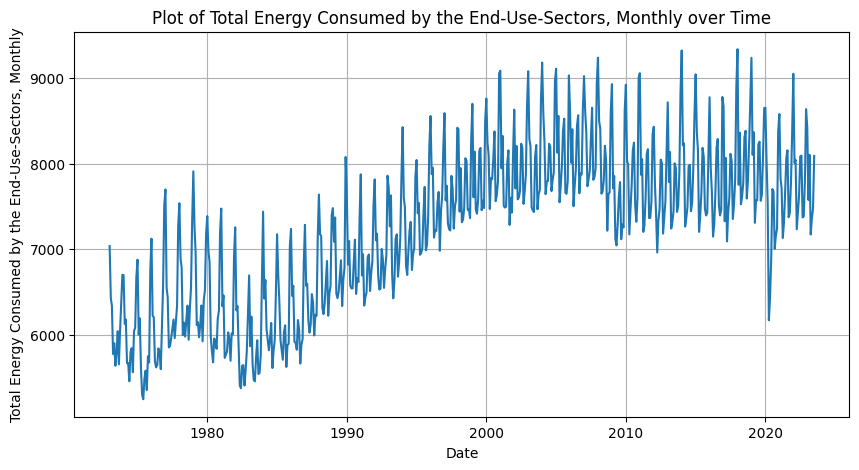

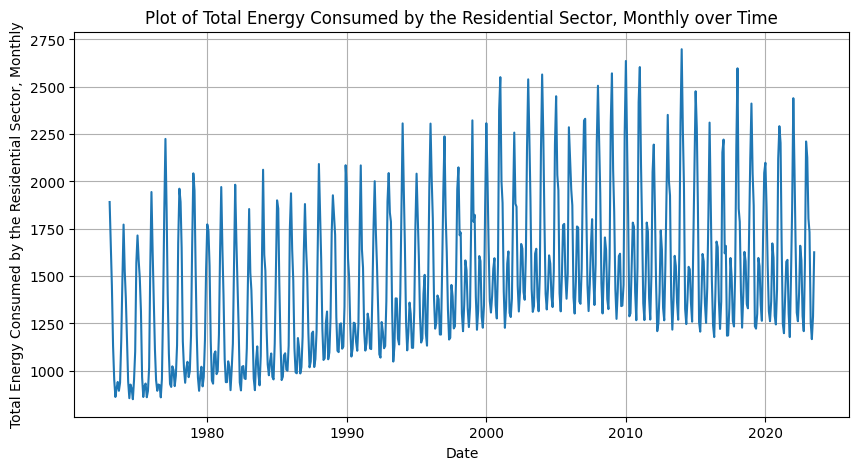

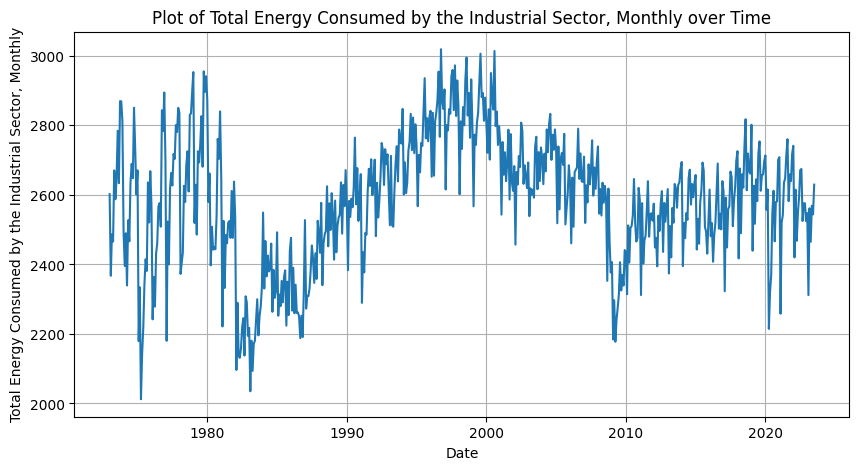

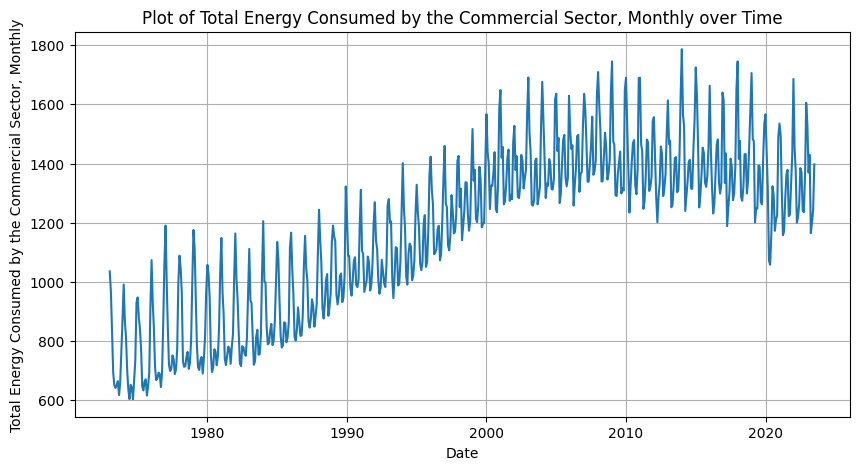

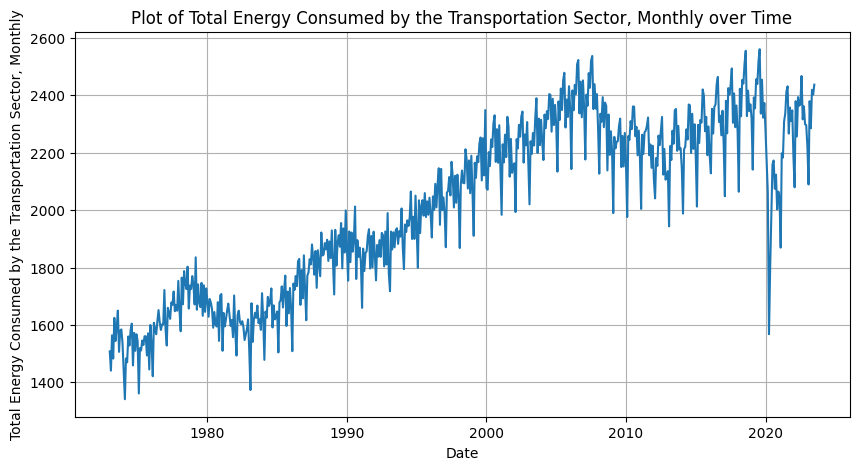

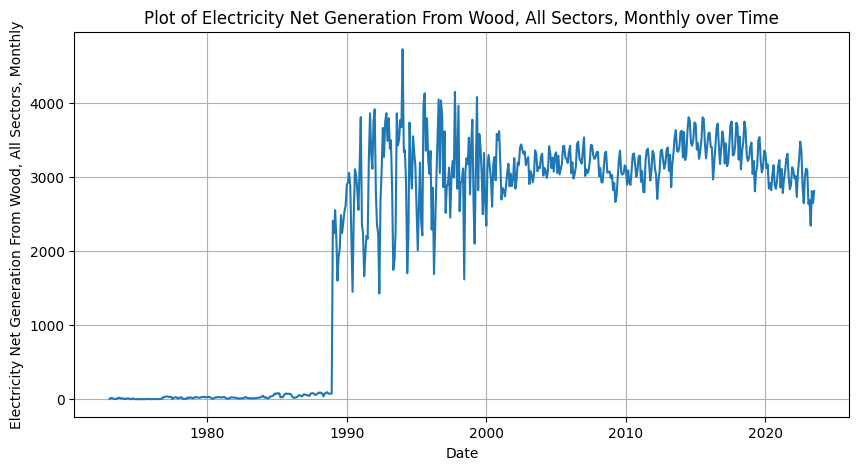

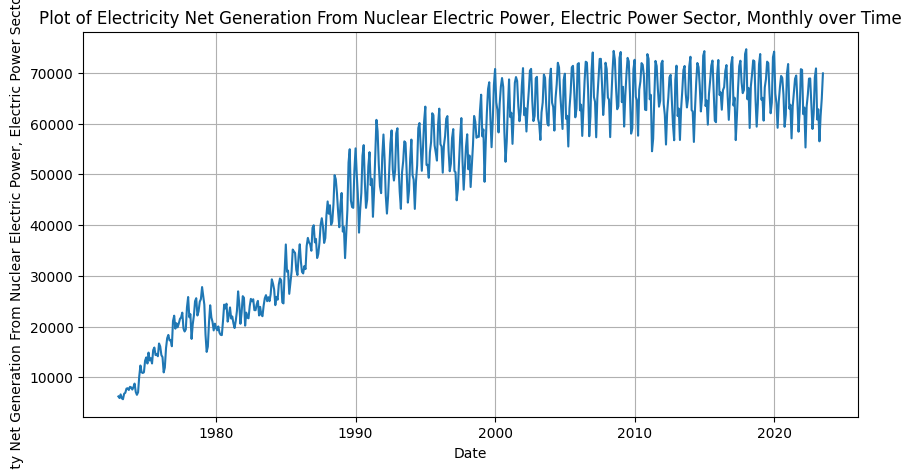

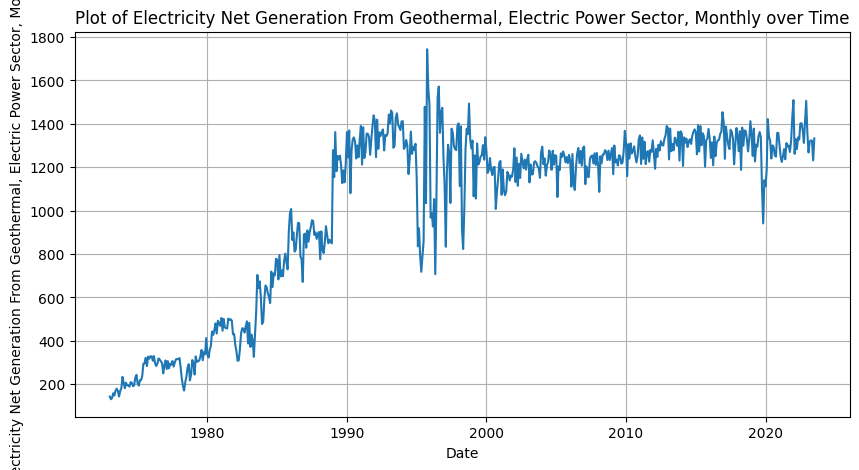

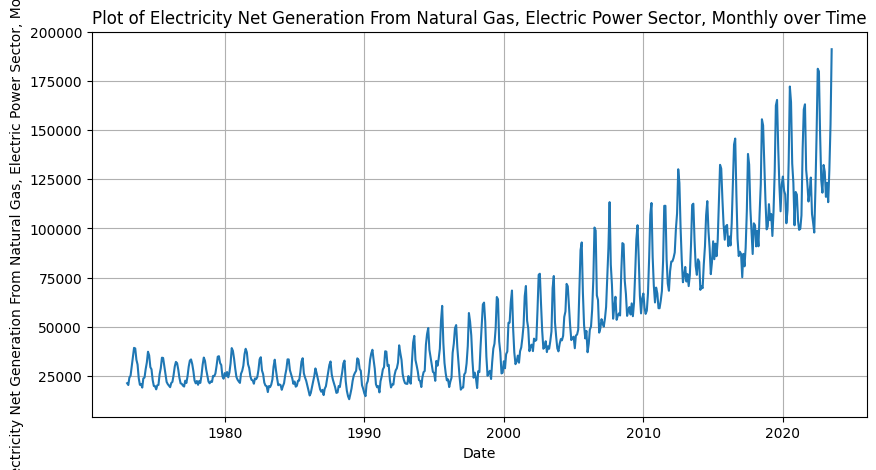

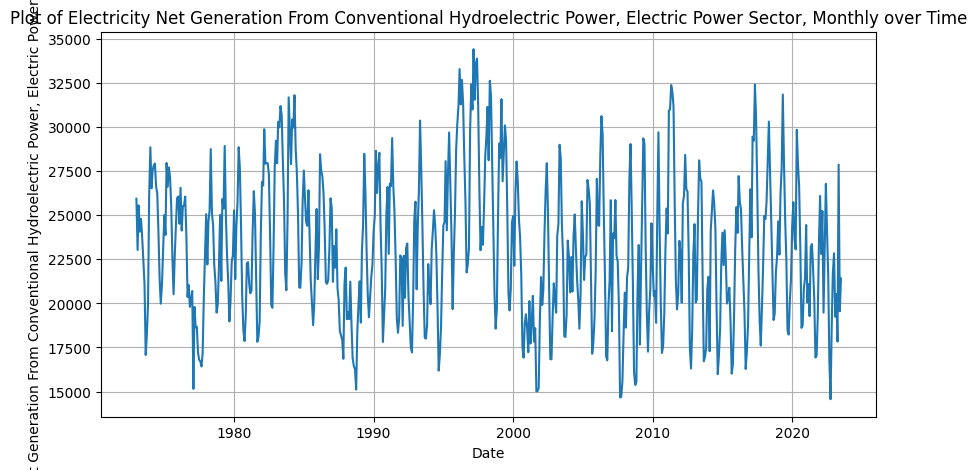

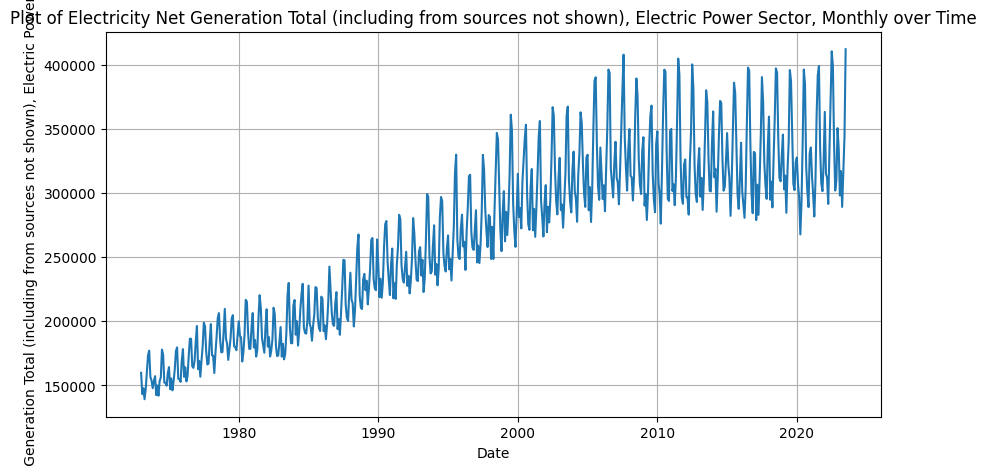

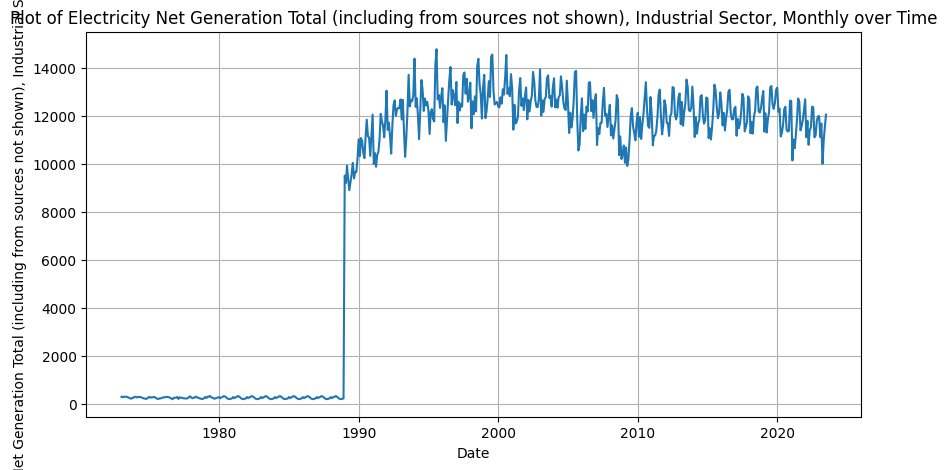

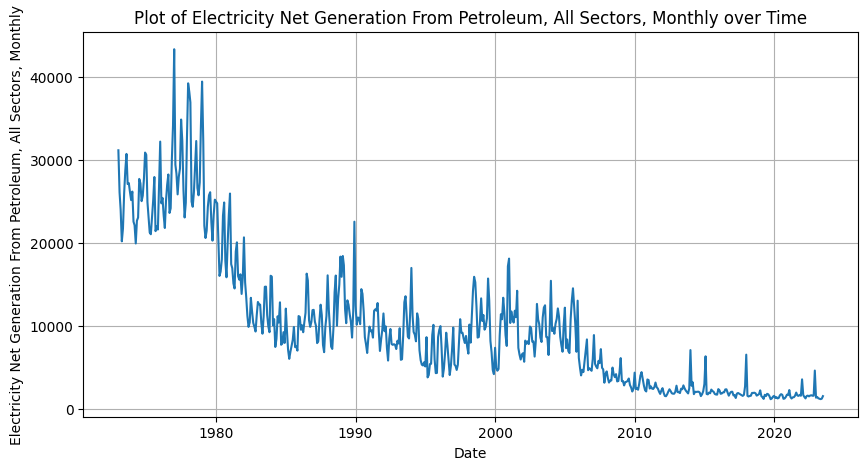

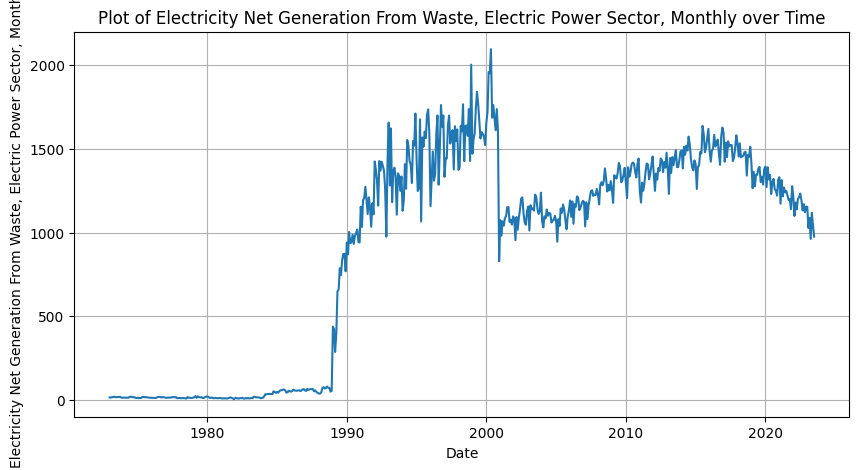

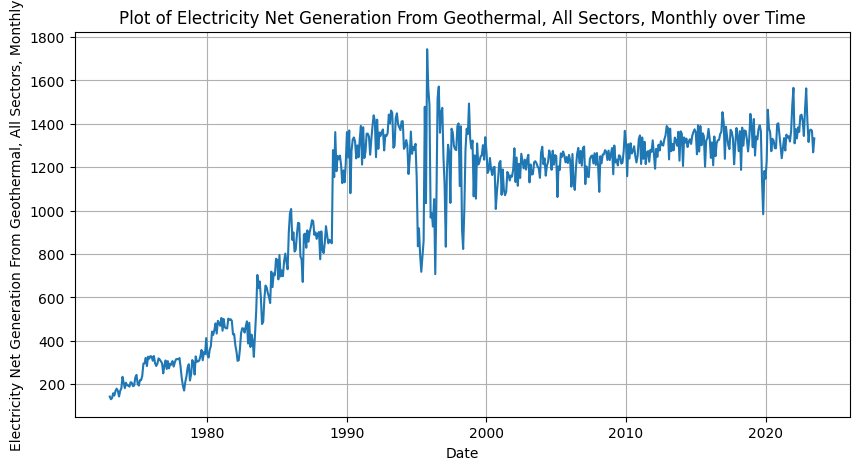

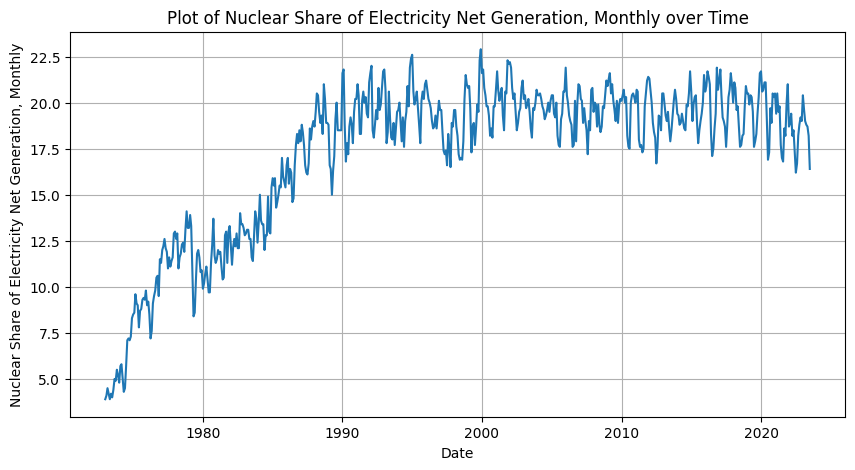

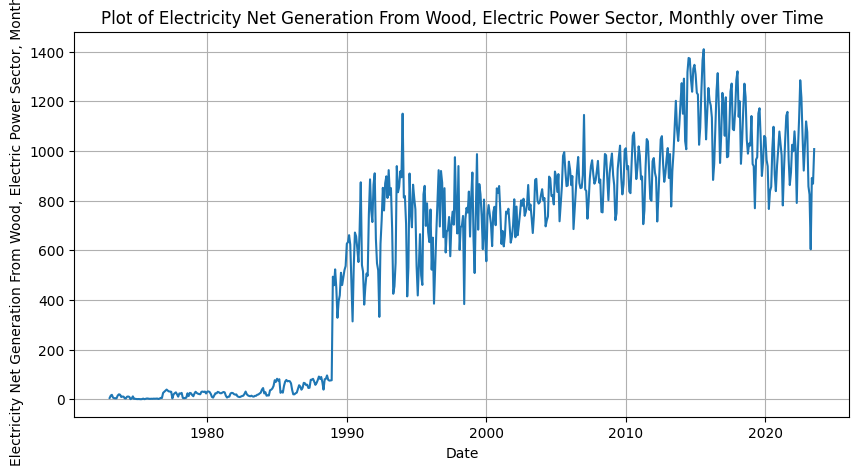

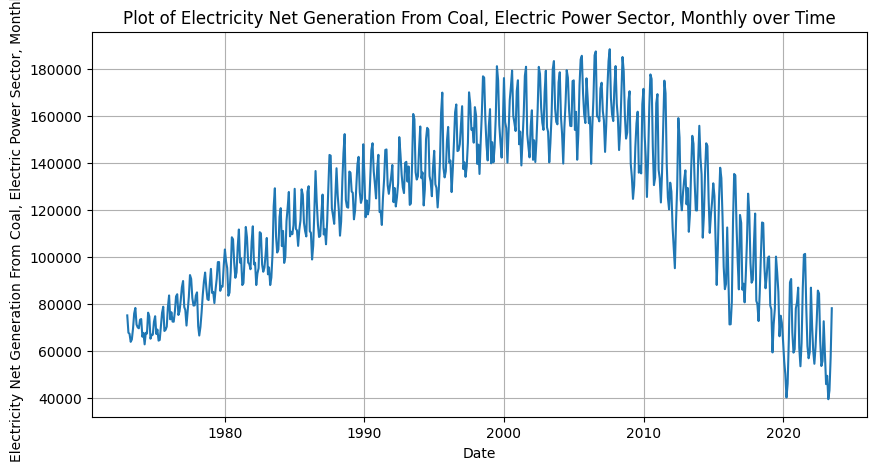

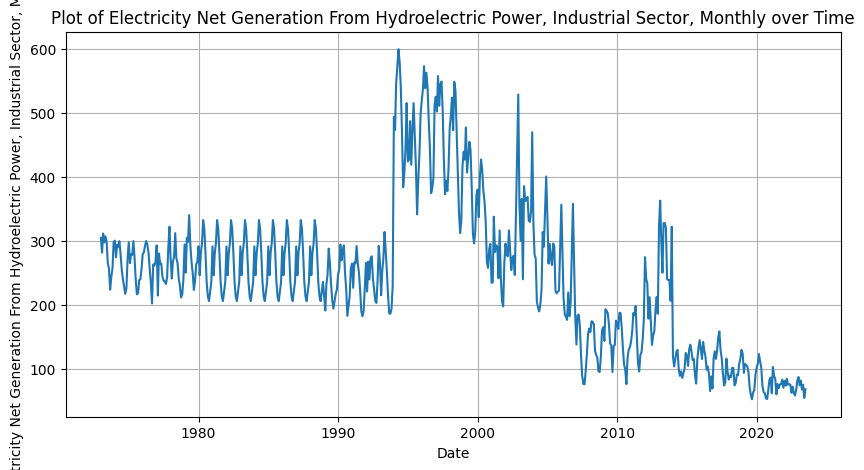

In [ ]:
columns_to_plot = [col for col in merged_df.columns if col != "Date"]

# Iterate over each column and plot
for col in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(merged_df["Date"], merged_df[col])
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.title(f"Plot of {col} over Time")
    plt.grid(True)
    plt.show()

In [ ]:
# # Create a "Seasons" column based on the month of the year
# merged_df['Seasons'] = merged_df['Date'].dt.month.map({
#     1: 'Winter',
#     2: 'Winter',
#     3: 'Spring',
#     4: 'Spring',
#     5: 'Spring',
#     6: 'Summer',
#     7: 'Summer',
#     8: 'Summer',
#     9: 'Fall',
#     10: 'Fall',
#     11: 'Fall',
#     12: 'Winter'
# })


In [ ]:
# merged_df['Week'] = merged_df['Date'].dt.week
# # merged_df['Hour'] = merged_df['Date'].dt.hour

In [ ]:
# from datetime import date, timedelta
# # Function to calculate certain dynamic holidays
# def calculate_holiday(year, month, day_of_week, occurrence):
#     first_day = date(year, month, 1)
#     day_shift = (day_of_week - first_day.weekday() + 7) % 7
#     holiday = first_day + timedelta(days=day_shift + (occurrence - 1) * 7)
#     return holiday

# # Adding holidays to the DataFrame
# merged_df['Holiday'] = merged_df['Date'].apply(lambda x:
#     "New Year's Day" if x.month == 1 and x.day == 1 else
#     "Martin Luther King Jr. Day" if x == calculate_holiday(x.year, 1, 0, 3) else
#     "Presidents' Day" if x == calculate_holiday(x.year, 2, 0, 3) else
#     "Memorial Day" if x == calculate_holiday(x.year, 5, 0, -1) else
#     "Independence Day" if x.month == 7 and x.day == 4 else
#     "Labor Day" if x == calculate_holiday(x.year, 9, 0, 1) else
#     "Columbus Day" if x == calculate_holiday(x.year, 10, 0, 2) else
#     "Veterans Day" if x.month == 11 and x.day == 11 else
#     "Thanksgiving Day" if x == calculate_holiday(x.year, 11, 3, 4) else
#     "Christmas Day" if x.month == 12 and x.day == 25 else
#     None
# )

# # Filling non-holiday dates with 'No Holiday'
# merged_df['Holiday'].fillna('No Holiday', inplace=True)

In [ ]:
merged_df

Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
0   1973-01-01                                           7036.038       
1   1973-02-01                                           6426.142       
2   1973-03-01                                           6340.899       
3   1973-04-01                                           5772.216       
4   1973-05-01                                           5898.599       
..         ...                                                ...       
602 2023-03-01                                           8102.717       
603 2023-04-01                                           7170.783       
604 2023-05-01                                           7353.173       
605 2023-06-01                                           7478.702       
606 2023-07-01                                           8089.522       

     Total Energy Consumed by the Residential Sector, Monthly  \
0                                             1891.085          
1                                             1654.702          
2                                             1449.509          
3                                             1129.599          
4                                              953.569          
..                                                 ...          
602                                           1731.647          
603                                           1255.769          
604                                           1166.811          
605                                           1287.425          
606                                           1625.598          

     Total Energy Consumed by the Industrial Sector, Monthly  \
0                                             2602.134         
1                                             2367.405         
2                                             2486.493         
3                                             2465.954         
4                                             2670.393         
..                                                 ...         
602                                           2561.443         
603                                           2465.071         
604                                           2568.771         
605                                           2544.021         
606                                           2629.522         

     Total Energy Consumed by the Commercial Sector, Monthly  \
0                                             1035.184         
1                                              963.267         
2                                              841.078         
3                                              693.905         
4                                              649.991         
..                                                 ...         
602                                           1429.798         
603                                           1164.578         
604                                           1198.424         
605                                           1244.970         
606                                           1397.015         

     Total Energy Consumed by the Transportation Sector, Monthly  \
0                                             1507.635             
1                                             1440.768             
2                                             1563.818             
3                                             1482.758             
4                                             1624.645             
..                                                 ...             
602                                           2379.829             
603                                           2285.366             
604                                           2419.168             
605                                           2402.287             
606                                           2437.387            

In [ ]:
merged_df

Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
0   1973-01-01                                           7036.038       
1   1973-02-01                                           6426.142       
2   1973-03-01                                           6340.899       
3   1973-04-01                                           5772.216       
4   1973-05-01                                           5898.599       
..         ...                                                ...       
602 2023-03-01                                           8102.717       
603 2023-04-01                                           7170.783       
604 2023-05-01                                           7353.173       
605 2023-06-01                                           7478.702       
606 2023-07-01                                           8089.522       

     Total Energy Consumed by the Residential Sector, Monthly  \
0                                             1891.085          
1                                             1654.702          
2                                             1449.509          
3                                             1129.599          
4                                              953.569          
..                                                 ...          
602                                           1731.647          
603                                           1255.769          
604                                           1166.811          
605                                           1287.425          
606                                           1625.598          

     Total Energy Consumed by the Industrial Sector, Monthly  \
0                                             2602.134         
1                                             2367.405         
2                                             2486.493         
3                                             2465.954         
4                                             2670.393         
..                                                 ...         
602                                           2561.443         
603                                           2465.071         
604                                           2568.771         
605                                           2544.021         
606                                           2629.522         

     Total Energy Consumed by the Commercial Sector, Monthly  \
0                                             1035.184         
1                                              963.267         
2                                              841.078         
3                                              693.905         
4                                              649.991         
..                                                 ...         
602                                           1429.798         
603                                           1164.578         
604                                           1198.424         
605                                           1244.970         
606                                           1397.015         

     Total Energy Consumed by the Transportation Sector, Monthly  \
0                                             1507.635             
1                                             1440.768             
2                                             1563.818             
3                                             1482.758             
4                                             1624.645             
..                                                 ...             
602                                           2379.829             
603                                           2285.366             
604                                           2419.168             
605                                           2402.287             
606                                           2437.387            

In [ ]:
merged_df.Week.nunique()

24

In [ ]:
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['Week_Number'] = merged_df['Date'].dt.isocalendar().week
merged_df['Day_of_Week'] = merged_df['Date'].dt.day_name()
merged_df['Is_Weekend'] = merged_df['Date'].dt.weekday >= 5
merged_df['Quarter'] = merged_df['Date'].dt.quarter

# Assuming you have a function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

merged_df['Season'] = merged_df['Month'].apply(get_season)


Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
0   1973-01-01                                           7036.038       
1   1973-02-01                                           6426.142       
2   1973-03-01                                           6340.899       
3   1973-04-01                                           5772.216       
4   1973-05-01                                           5898.599       
..         ...                                                ...       
602 2023-03-01                                           8102.717       
603 2023-04-01                                           7170.783       
604 2023-05-01                                           7353.173       
605 2023-06-01                                           7478.702       
606 2023-07-01                                           8089.522       

     Total Energy Consumed by the Residential Sector, Monthly  \
0                                             1891.085          
1                                             1654.702          
2                                             1449.509          
3                                             1129.599          
4                                              953.569          
..                                                 ...          
602                                           1731.647          
603                                           1255.769          
604                                           1166.811          
605                                           1287.425          
606                                           1625.598          

     Total Energy Consumed by the Industrial Sector, Monthly  \
0                                             2602.134         
1                                             2367.405         
2                                             2486.493         
3                                             2465.954         
4                                             2670.393         
..                                                 ...         
602                                           2561.443         
603                                           2465.071         
604                                           2568.771         
605                                           2544.021         
606                                           2629.522         

     Total Energy Consumed by the Commercial Sector, Monthly  \
0                                             1035.184         
1                                              963.267         
2                                              841.078         
3                                              693.905         
4                                              649.991         
..                                                 ...         
602                                           1429.798         
603                                           1164.578         
604                                           1198.424         
605                                           1244.970         
606                                           1397.015         

     Total Energy Consumed by the Transportation Sector, Monthly  \
0                                             1507.635             
1                                             1440.768             
2                                             1563.818             
3                                             1482.758             
4                                             1624.645             
..                                                 ...             
602                                           2379.829             
603                                           2285.366             
604                                           2419.168             
605                                           2402.287             
606                                           2437.387            

In [ ]:
# merged_df = merged_df.drop(columns=['Seasons','Day','Week_Number'])
merged_df = merged_df.drop(columns=['Week_Number'])

In [ ]:
merged_df

Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
0   1973-01-01                                           7036.038       
1   1973-02-01                                           6426.142       
2   1973-03-01                                           6340.899       
3   1973-04-01                                           5772.216       
4   1973-05-01                                           5898.599       
..         ...                                                ...       
602 2023-03-01                                           8102.717       
603 2023-04-01                                           7170.783       
604 2023-05-01                                           7353.173       
605 2023-06-01                                           7478.702       
606 2023-07-01                                           8089.522       

     Total Energy Consumed by the Residential Sector, Monthly  \
0                                             1891.085          
1                                             1654.702          
2                                             1449.509          
3                                             1129.599          
4                                              953.569          
..                                                 ...          
602                                           1731.647          
603                                           1255.769          
604                                           1166.811          
605                                           1287.425          
606                                           1625.598          

     Total Energy Consumed by the Industrial Sector, Monthly  \
0                                             2602.134         
1                                             2367.405         
2                                             2486.493         
3                                             2465.954         
4                                             2670.393         
..                                                 ...         
602                                           2561.443         
603                                           2465.071         
604                                           2568.771         
605                                           2544.021         
606                                           2629.522         

     Total Energy Consumed by the Commercial Sector, Monthly  \
0                                             1035.184         
1                                              963.267         
2                                              841.078         
3                                              693.905         
4                                              649.991         
..                                                 ...         
602                                           1429.798         
603                                           1164.578         
604                                           1198.424         
605                                           1244.970         
606                                           1397.015         

     Total Energy Consumed by the Transportation Sector, Monthly  \
0                                             1507.635             
1                                             1440.768             
2                                             1563.818             
3                                             1482.758             
4                                             1624.645             
..                                                 ...             
602                                           2379.829             
603                                           2285.366             
604                                           2419.168             
605                                           2402.287             
606                                           2437.387            

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode "Day_of_Week" column
merged_df['Day_of_Week'] = label_encoder.fit_transform(merged_df['Day_of_Week'])

# Encode "Is_Weekend" column
merged_df['Is_Weekend'] = label_encoder.fit_transform(merged_df['Is_Weekend'])

# Encode "Season" column
merged_df['Season'] = label_encoder.fit_transform(merged_df['Season'])

merged_df

Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
0   1973-01-01                                           7036.038       
1   1973-02-01                                           6426.142       
2   1973-03-01                                           6340.899       
3   1973-04-01                                           5772.216       
4   1973-05-01                                           5898.599       
..         ...                                                ...       
602 2023-03-01                                           8102.717       
603 2023-04-01                                           7170.783       
604 2023-05-01                                           7353.173       
605 2023-06-01                                           7478.702       
606 2023-07-01                                           8089.522       

     Total Energy Consumed by the Residential Sector, Monthly  \
0                                             1891.085          
1                                             1654.702          
2                                             1449.509          
3                                             1129.599          
4                                              953.569          
..                                                 ...          
602                                           1731.647          
603                                           1255.769          
604                                           1166.811          
605                                           1287.425          
606                                           1625.598          

     Total Energy Consumed by the Industrial Sector, Monthly  \
0                                             2602.134         
1                                             2367.405         
2                                             2486.493         
3                                             2465.954         
4                                             2670.393         
..                                                 ...         
602                                           2561.443         
603                                           2465.071         
604                                           2568.771         
605                                           2544.021         
606                                           2629.522         

     Total Energy Consumed by the Commercial Sector, Monthly  \
0                                             1035.184         
1                                              963.267         
2                                              841.078         
3                                              693.905         
4                                              649.991         
..                                                 ...         
602                                           1429.798         
603                                           1164.578         
604                                           1198.424         
605                                           1244.970         
606                                           1397.015         

     Total Energy Consumed by the Transportation Sector, Monthly  \
0                                             1507.635             
1                                             1440.768             
2                                             1563.818             
3                                             1482.758             
4                                             1624.645             
..                                                 ...             
602                                           2379.829             
603                                           2285.366             
604                                           2419.168             
605                                           2402.287             
606                                           2437.387            

In [ ]:
# merged_df.to_csv('total.csv', index=False)
data = merged_df

In [ ]:
# Creating a new dataframe with the specified columns
date_columns = ['Week', 'Year', 'Month', 'Day_of_Week', 'Is_Weekend', 'Quarter', 'Season']
date_df = data[date_columns]

# Dropping these columns from the main dataframe
data_dropped = data.drop(columns=date_columns)

date_df.head(), data_dropped.head()


(   Week  Year  Month  Day_of_Week  Is_Weekend  Quarter  Season
 0     1  1973      1            1           0        1       3
 1     5  1973      2            4           0        1       3
 2     9  1973      3            4           0        1       1
 3    13  1973      4            3           1        2       1
 4    18  1973      5            5           0        2       1,
         Date  Total Energy Consumed by the End-Use-Sectors, Monthly  \
 0 1973-01-01                                           7036.038       
 1 1973-02-01                                           6426.142       
 2 1973-03-01                                           6340.899       
 3 1973-04-01                                           5772.216       
 4 1973-05-01                                           5898.599       
 
    Total Energy Consumed by the Residential Sector, Monthly  \
 0                                           1891.085          
 1                                           1654.702

In [ ]:

# Function to detect outliers using the Interquartile Range (IQR) method
def detect_outliers_iqr(data, feature):
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    IQR = Q3 - Q1

    outlier_step = 1.5 * IQR

    outliers = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step)]
    return outliers

# Applying outlier detection for each column in the main dataframe
outlier_analysis = {}

for column in data_dropped.columns:
    # Skip non-numeric columns
    if data_dropped[column].dtype == 'object':
        continue

    outlier_analysis[column] = detect_outliers_iqr(data_dropped, column)

# Displaying the number of outliers detected for each column
outlier_counts = {column: len(outliers) for column, outliers in outlier_analysis.items()}
outlier_counts

{'Date': 0,
 'Total Energy Consumed by the End-Use-Sectors, Monthly': 0,
 'Total Energy Consumed by the Residential Sector, Monthly': 8,
 'Total Energy Consumed by the Industrial Sector, Monthly': 4,
 'Total Energy Consumed by the Commercial Sector, Monthly': 0,
 'Total Energy Consumed by the Transportation Sector, Monthly': 0,
 'Electricity Net Generation From Wood, All Sectors, Monthly': 0,
 'Electricity Net Generation From Nuclear Electric Power, Electric Power Sector, Monthly': 0,
 'Electricity Net Generation From Geothermal, Electric Power Sector, Monthly': 0,
 'Electricity Net Generation From Natural Gas, Electric Power Sector, Monthly': 10,
 'Electricity Net Generation From Conventional Hydroelectric Power, Electric Power Sector, Monthly': 0,
 'Electricity Net Generation Total (including from sources not shown), Electric Power Sector, Monthly': 0,
 'Electricity Net Generation Total (including from sources not shown), Industrial Sector, Monthly': 0,
 'Electricity Net Generation F

Test MSE: 191964.700


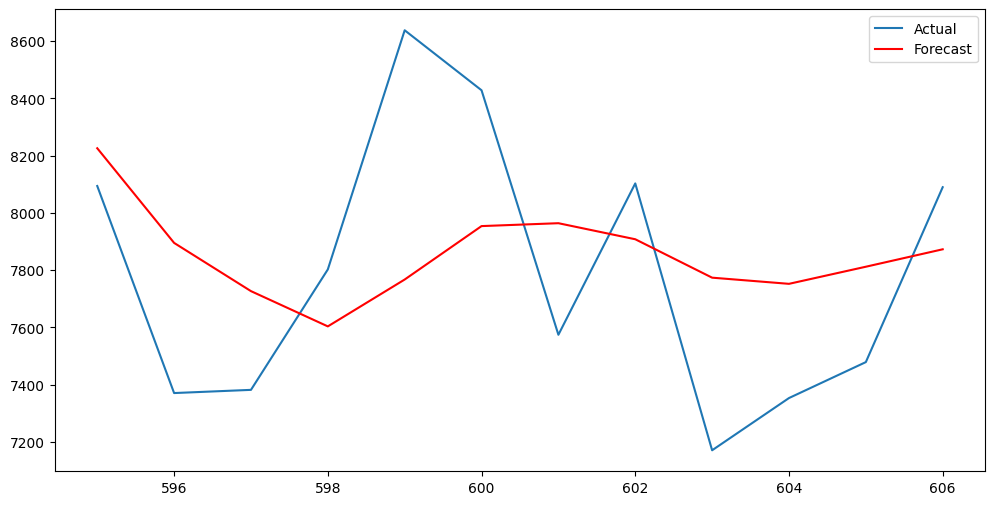

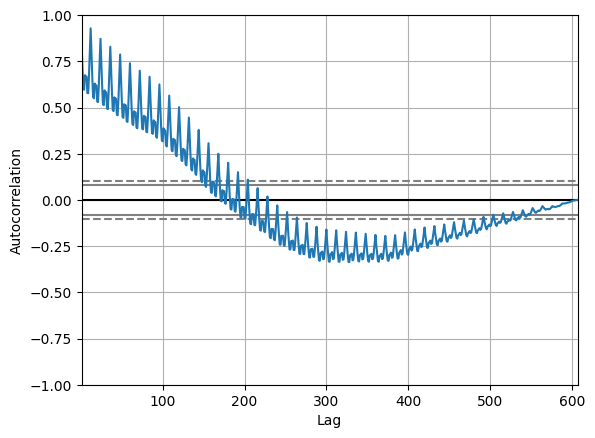

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Selecting the series to forecast
series = data['Total Energy Consumed by the End-Use-Sectors, Monthly']

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Setting the 'Date' as the index
data.set_index('Date', inplace=True)

# Forecasting horizon (12 months)
forecasting_horizon = 12

# Splitting the data into train and test
# We leave the last 12 months for testing
train = series[:-forecasting_horizon]
test = series[-forecasting_horizon:]

# Fitting an ARIMA model
# For simplicity, we are using an ARIMA model without optimizing the parameters
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Forecasting the next 12 months
forecast = model_fit.forecast(steps=forecasting_horizon)

# Calculating the mean squared error
error = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % error)

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Autocorrelation plot for selecting lag features
autocorrelation_plot(series)
plt.show()


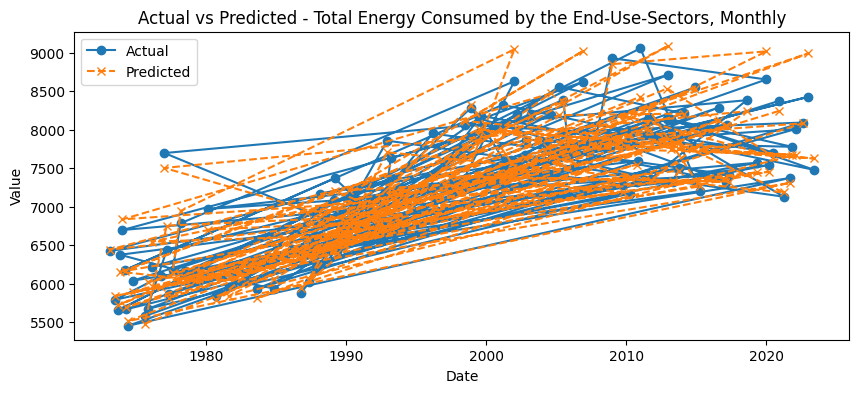

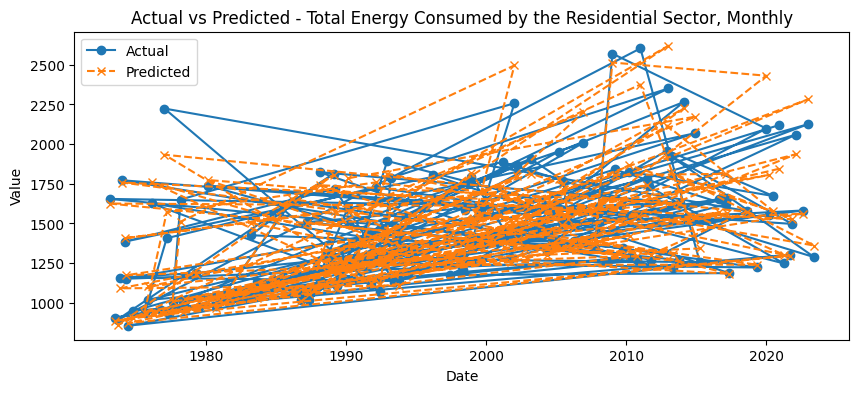

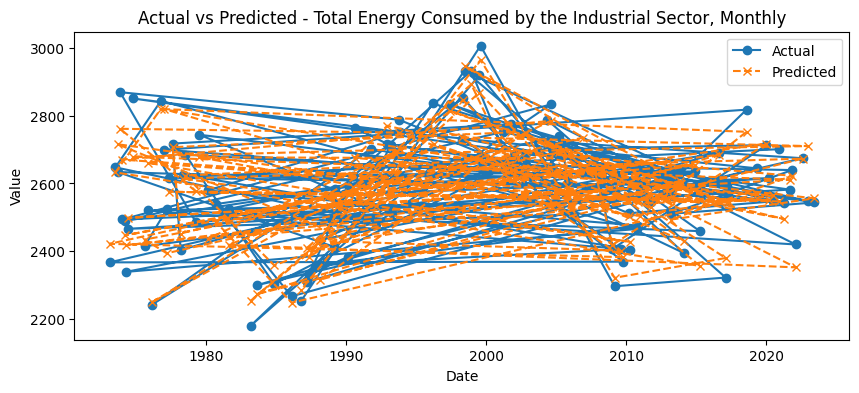

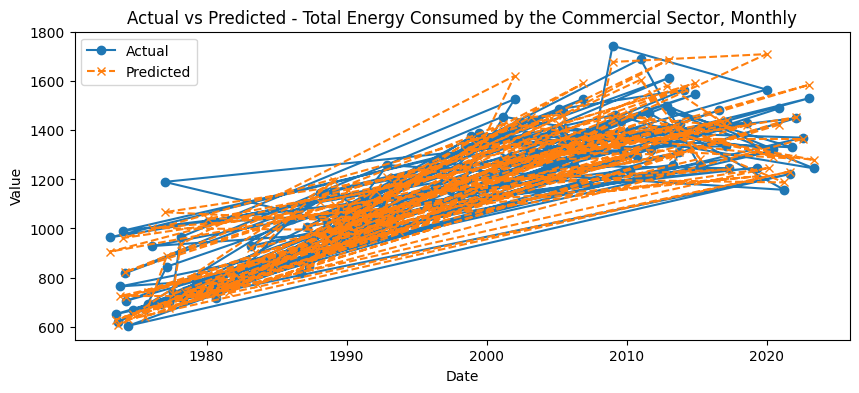

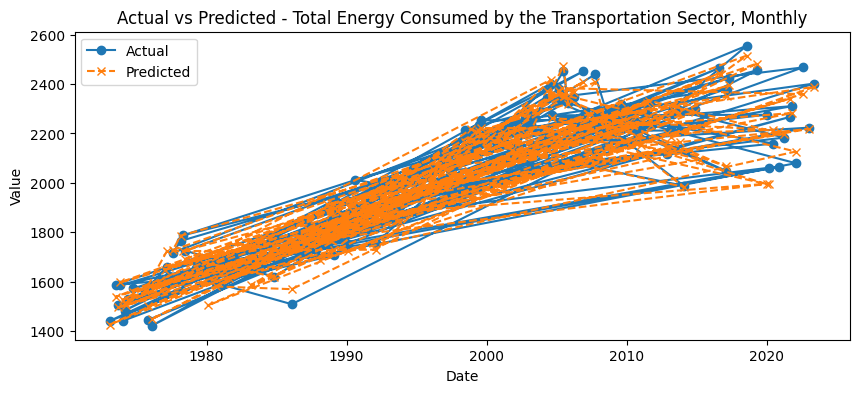

{'Total Energy Consumed by the End-Use-Sectors, Monthly': 39352.83384345116,
 'Total Energy Consumed by the Residential Sector, Monthly': 9797.557094804035,
 'Total Energy Consumed by the Industrial Sector, Monthly': 4197.455025032863,
 'Total Energy Consumed by the Commercial Sector, Monthly': 1971.7922655429588,
 'Total Energy Consumed by the Transportation Sector, Monthly': 2405.389184510071}

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Extracting relevant columns for X and y
X = data[['Week', 'Year', 'Month', 'Day_of_Week', 'Is_Weekend', 'Quarter', 'Season']]
energy_consumed_columns = [col for col in data.columns if col.startswith('Total Energy Consumed')]

# Dictionary to hold models and their performance
models_performance = {}

# Loop through each 'Total Energy Consumed' column to create a separate model
for column in energy_consumed_columns:
    y = data[column]

    # Splitting the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initializing and fitting the XGBoost model
    model = XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train, y_train)

    # Predicting and evaluating the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    models_performance[column] = mse

    # Plotting the actual vs predicted values for each model
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x', linestyle='--')
    plt.title(f'Actual vs Predicted - {column}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

models_performance


Modeling for: Total Energy Consumed by the End-Use-Sectors, Monthly
Training XGBoost...


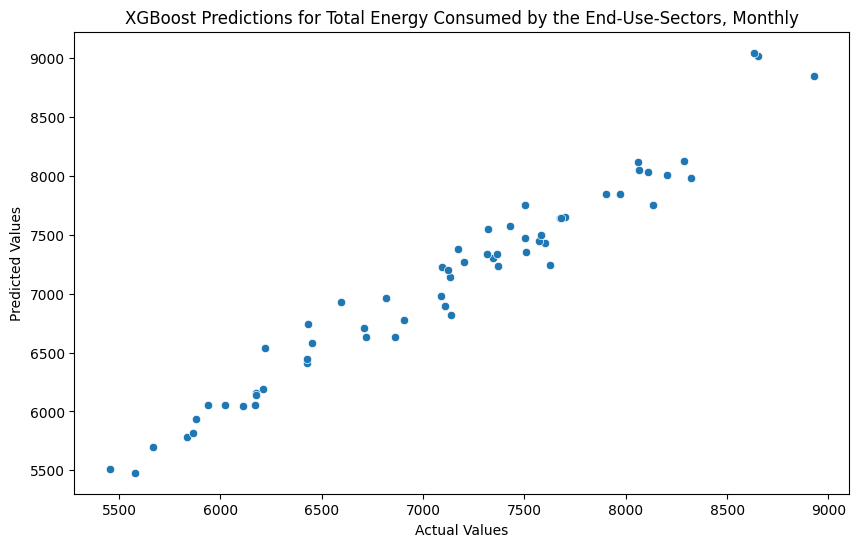

XGBoost Results for Total Energy Consumed by the End-Use-Sectors, Monthly:
Mean Absolute Error: 128.13, R2 Score: 0.96

Training Random Forest...


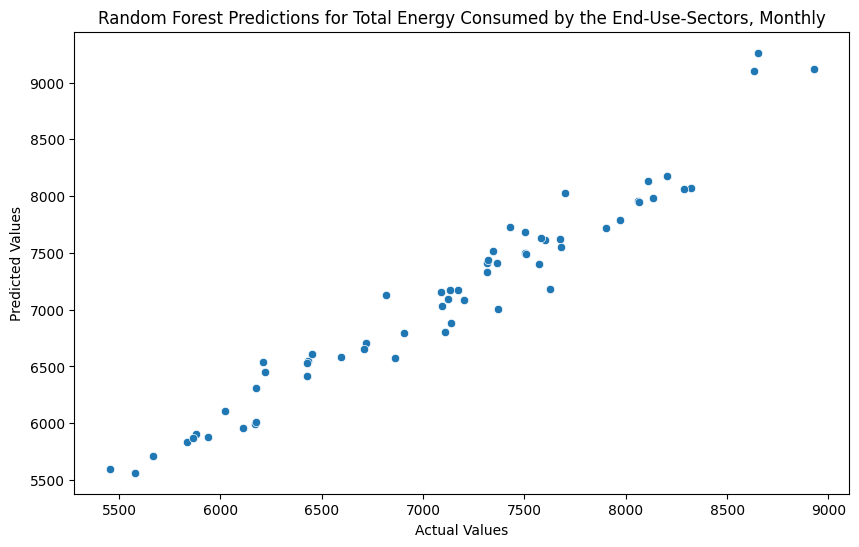

Random Forest Results for Total Energy Consumed by the End-Use-Sectors, Monthly:
Mean Absolute Error: 141.85, R2 Score: 0.95

Training Gradient Boosting...


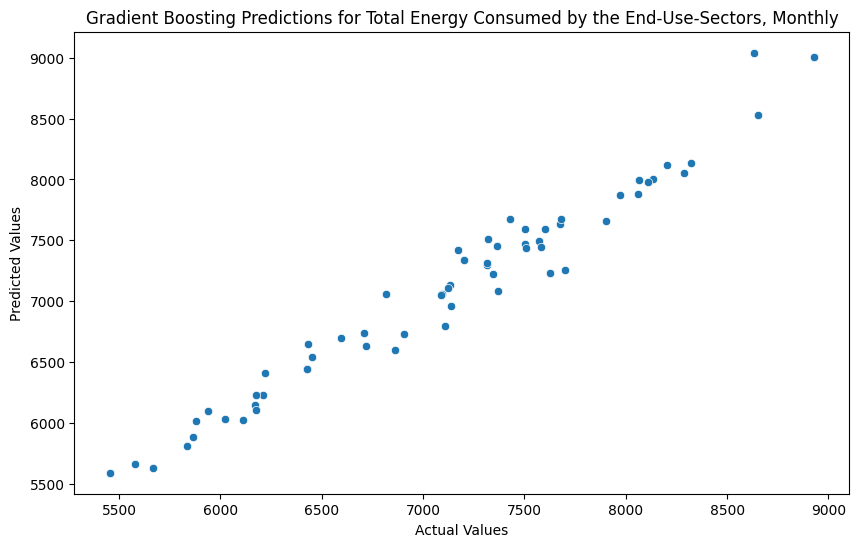

Gradient Boosting Results for Total Energy Consumed by the End-Use-Sectors, Monthly:
Mean Absolute Error: 122.51, R2 Score: 0.96

Modeling for: Total Energy Consumed by the Residential Sector, Monthly
Training XGBoost...


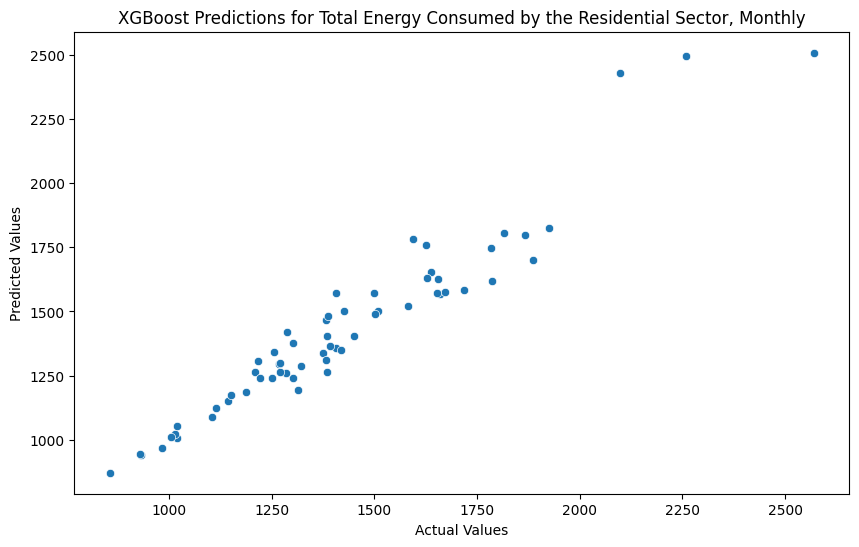

XGBoost Results for Total Energy Consumed by the Residential Sector, Monthly:
Mean Absolute Error: 64.42, R2 Score: 0.92

Training Random Forest...


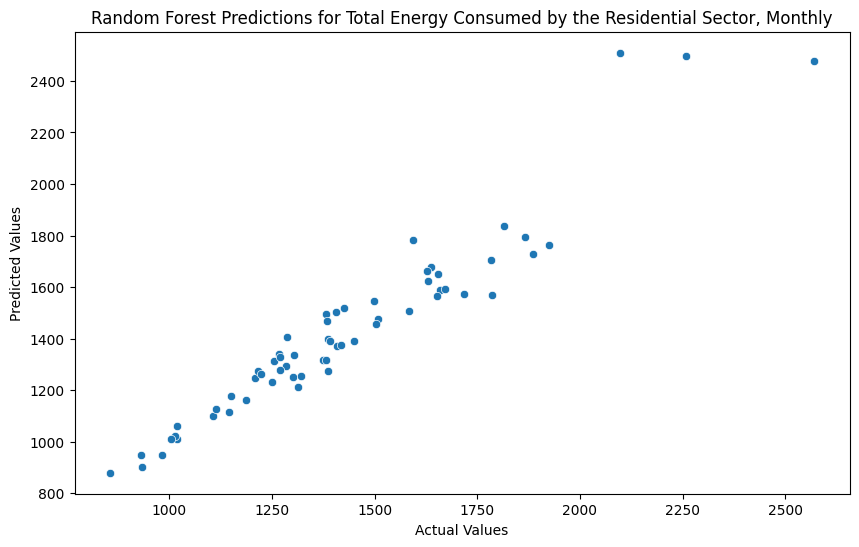

Random Forest Results for Total Energy Consumed by the Residential Sector, Monthly:
Mean Absolute Error: 67.11, R2 Score: 0.91

Training Gradient Boosting...


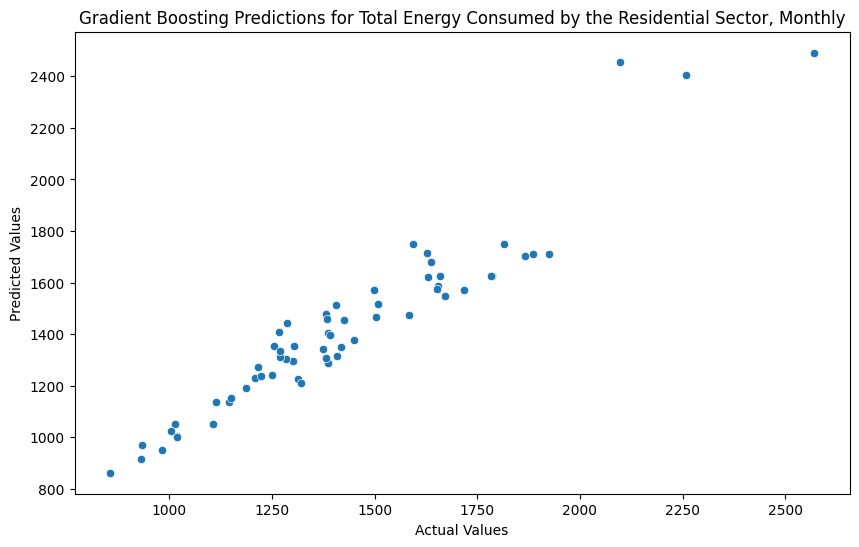

Gradient Boosting Results for Total Energy Consumed by the Residential Sector, Monthly:
Mean Absolute Error: 72.18, R2 Score: 0.91

Modeling for: Total Energy Consumed by the Industrial Sector, Monthly
Training XGBoost...


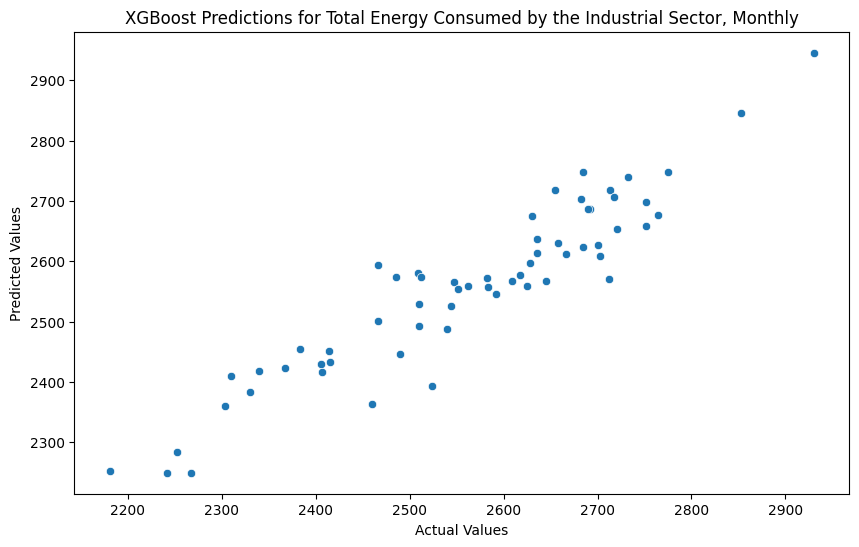

XGBoost Results for Total Energy Consumed by the Industrial Sector, Monthly:
Mean Absolute Error: 46.06, R2 Score: 0.87

Training Random Forest...


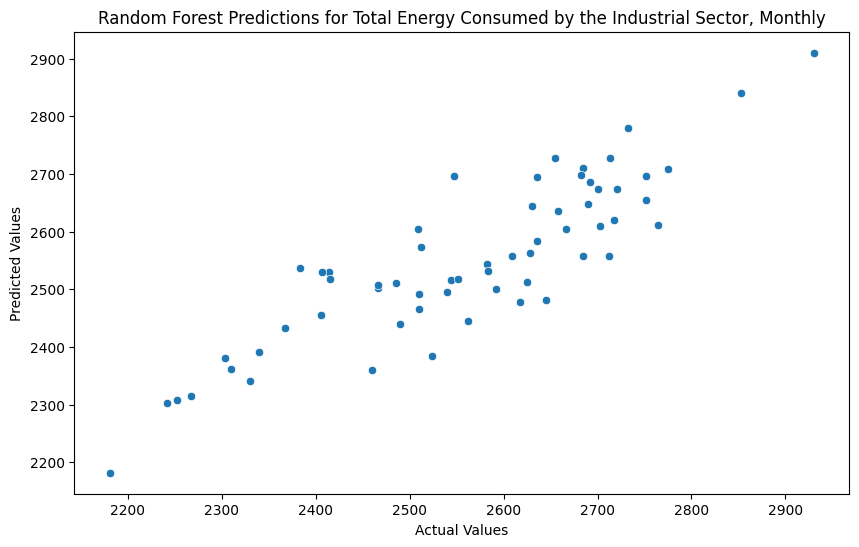

Random Forest Results for Total Energy Consumed by the Industrial Sector, Monthly:
Mean Absolute Error: 66.40, R2 Score: 0.76

Training Gradient Boosting...


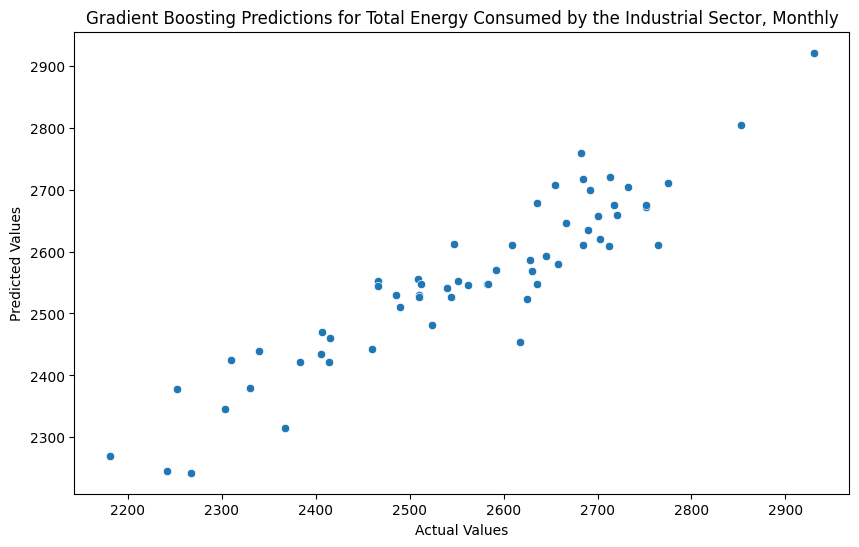

Gradient Boosting Results for Total Energy Consumed by the Industrial Sector, Monthly:
Mean Absolute Error: 51.35, R2 Score: 0.85

Modeling for: Total Energy Consumed by the Commercial Sector, Monthly
Training XGBoost...


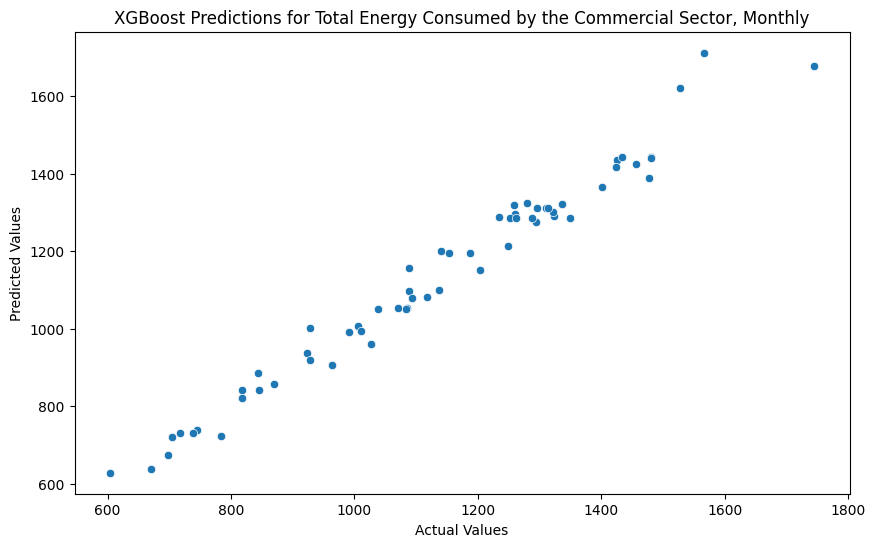

XGBoost Results for Total Energy Consumed by the Commercial Sector, Monthly:
Mean Absolute Error: 32.00, R2 Score: 0.97

Training Random Forest...


Random Forest Results for Total Energy Consumed by the Commercial Sector, Monthly:
Mean Absolute Error: 36.45, R2 Score: 0.96

Training Gradient Boosting...


Gradient Boosting Results for Total Energy Consumed by the Commercial Sector, Monthly:
Mean Absolute Error: 29.62, R2 Score: 0.98

Modeling for: Total Energy Consumed by the Transportation Sector, Monthly
Training XGBoost...


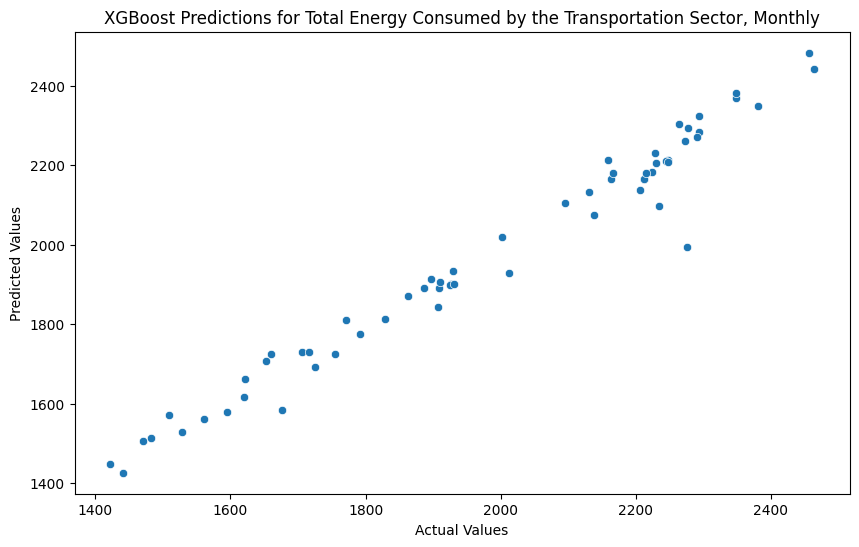

XGBoost Results for Total Energy Consumed by the Transportation Sector, Monthly:
Mean Absolute Error: 34.51, R2 Score: 0.97

Training Random Forest...


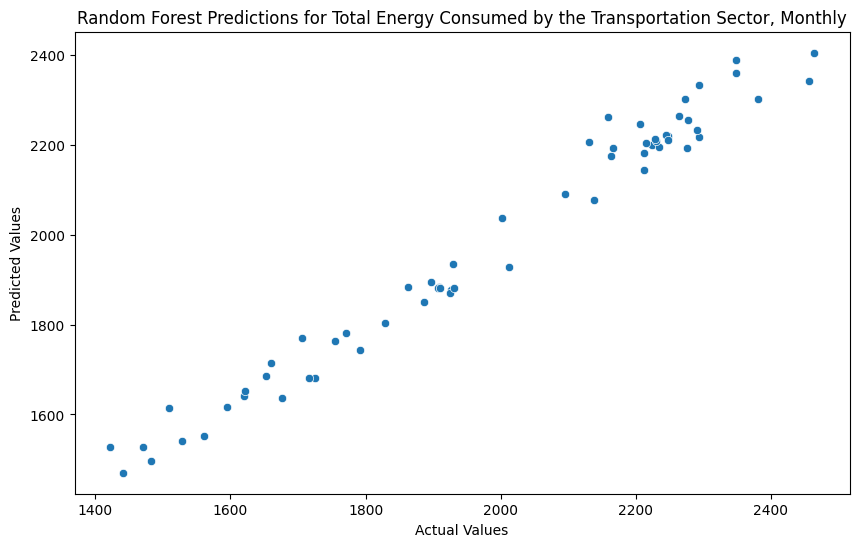

Random Forest Results for Total Energy Consumed by the Transportation Sector, Monthly:
Mean Absolute Error: 39.62, R2 Score: 0.97

Training Gradient Boosting...


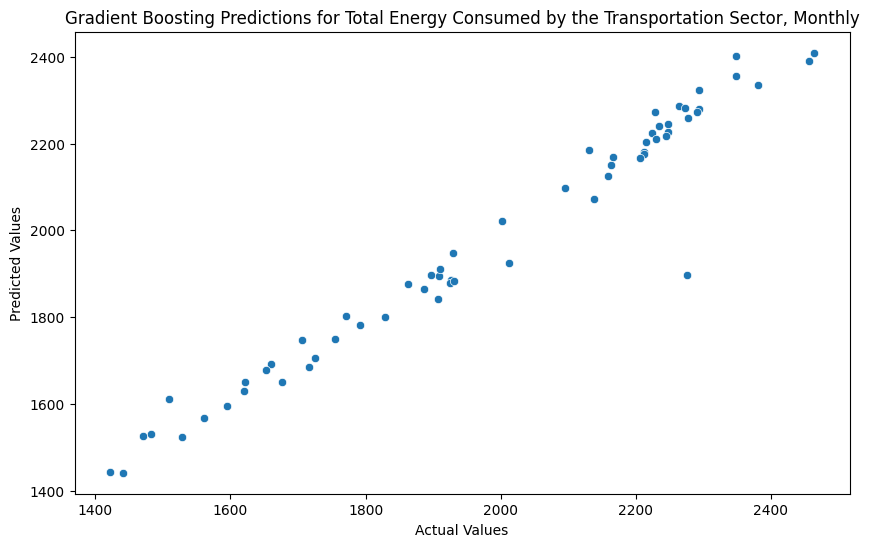

Gradient Boosting Results for Total Energy Consumed by the Transportation Sector, Monthly:
Mean Absolute Error: 33.41, R2 Score: 0.96



Mean Absolute Error  \
Total Energy Consumed by the End-Use-Sectors, M...           128.132630   
Total Energy Consumed by the End-Use-Sectors, M...           141.854748   
Total Energy Consumed by the End-Use-Sectors, M...           122.509133   
Total Energy Consumed by the Residential Sector...            64.417891   
Total Energy Consumed by the Residential Sector...            67.110553   
Total Energy Consumed by the Residential Sector...            72.175443   
Total Energy Consumed by the Industrial Sector,...            46.055262   
Total Energy Consumed by the Industrial Sector,...            66.401180   
Total Energy Consumed by the Industrial Sector,...            51.345358   
Total Energy Consumed by the Commercial Sector,...            32.001068   
Total Energy Consumed by the Commercial Sector,...            36.450990   
Total Energy Consumed by the Commercial Sector,...            29.621422   
Total Energy Consumed by the Transportation Sec...            34.512789   
Total Energy Consumed by the Transportation Sec...            39.615423   
Total Energy Consumed by the Transportation Sec...            33.411139   

                                                    R2 Score  
Total Energy Consumed by the End-Use-Sectors, M...  0.958284  
Total Energy Consumed by the End-Use-Sectors, M...  0.946962  
Total Energy Consumed by the End-Use-Sectors, M...  0.962371  
Total Energy Consumed by the Residential Sector...  0.922282  
Total Energy Consumed by the Residential Sector...  0.913997  
Total Energy Consumed by the Residential Sector...  0.911861  
Total Energy Consumed by the Industrial Sector,...  0.871554  
Total Energy Consumed by the Industrial Sector,...  0.755950  
Total Energy Consumed by the Industrial Sector,...  0.846913  
Total Energy Consumed by the Commercial Sector,...  0.973591  
Total Energy Consumed by the Commercial Sector,...  0.963989  
Total Energy Consumed by the Commercial Sector,...  0.977985  
Total Energy Consumed by the Transportation Sec...  0.966924  
Total Energy Consumed by the Transportation Sec...  0.972865  
Total Energy Consumed by the Transportation Sec...  0.958025

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the feature columns and the target columns
X_columns = ['Week', 'Year', 'Month', 'Day_of_Week', 'Is_Weekend', 'Quarter', 'Season']
target_columns = [col for col in data.columns if col.startswith('Total Energy Consumed')]

# Results storage
results = {}

# Iterating over each target column
for target in target_columns:
    print(f"Modeling for: {target}")

    # Preparing the data
    X = data[X_columns]
    y = data[target]

    # Splitting the data into train, validation, and test sets (80:10:10)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

    # Models: XGBoost, Random Forest, Gradient Boosting Machines
    models = {
        "XGBoost": xgb.XGBRegressor(n_estimators=1000, random_state=0),
        "Random Forest": RandomForestRegressor(random_state=0),
        "Gradient Boosting": GradientBoostingRegressor(random_state=0)
    }

    # Training and evaluating each model
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Calculating the metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[f"{target} - {model_name}"] = (mae, r2)

        # Plotting
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred)
        plt.title(f"{model_name} Predictions for {target}")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.show()

        print(f"{model_name} Results for {target}:")
        print(f"Mean Absolute Error: {mae:.2f}, R2 Score: {r2:.2f}\n")

# Displaying the results
results_df = pd.DataFrame(results, index=["Mean Absolute Error", "R2 Score"]).T
results_df


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, GRU
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# # Preprocessing - Scaling the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(data[X_columns])

# # Reshaping target variable (y) to be a 2D array
# y = np.array(data[y]).reshape(-1, 1)

# # Train/test split (80:10:10)
# X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# # Reshaping input data for LSTM, RNN, GRU (needed for time steps)
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# # LSTM Model
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
# lstm_model.add(Dense(1))
# lstm_model.compile(optimizer='adam', loss='mse')

# # Simple RNN Model
# rnn_model = Sequential()
# rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train.shape[2])))
# rnn_model.add(Dense(1))
# rnn_model.compile(optimizer='adam', loss='mse')

# # GRU Model
# gru_model = Sequential()
# gru_model.add(GRU(50, activation='relu', input_shape=(1, X_train.shape[2])))
# gru_model.add(Dense(1))
# gru_model.compile(optimizer='adam', loss='mse')

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, GRU
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'X_columns' are defined as before
X_columns = ['Week', 'Year', 'Month', 'Day_of_Week', 'Is_Weekend', 'Quarter', 'Season']

# Assuming 'target_column' is the name of your target column
# Replace 'target_column' with the actual column name
target_column = 'Total Energy Consumed by the End-Use-Sectors, Monthly'

# Preprocessing - Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[X_columns])

# Reshaping target variable (y) to be a 2D array
y = np.array(data[target_column]).reshape(-1, 1)

# Train/test split (80:10:10)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Reshaping input data for LSTM, RNN, GRU (needed for time steps)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Simple RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(1, X_train.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

# Model Summary (for LSTM, similar summaries can be generated for RNN and GRU)
lstm_model.summary()

# Uncomment the following lines to train the models (adjust epochs and batch size as needed)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11651 (45.51 KB)
Trainable params: 11651 (45.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 8s 70ms/step - loss: 53320892.0000 - val_loss: 55736088.0000
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 53319444.0000 - val_loss: 55734504.0000
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 53317860.0000 - val_loss: 55732676.0000
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 53

Evaluating LSTM model...
2/2 [==============================] - 0s 11ms/step


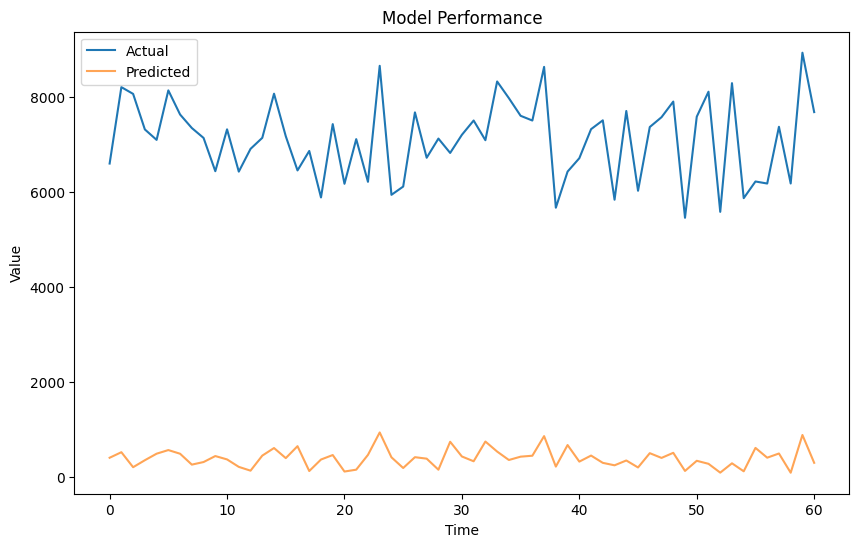

LSTM - MAE: 6714.470, R2 Score: -64.689

Evaluating Simple RNN model...
2/2 [==============================] - 0s 11ms/step


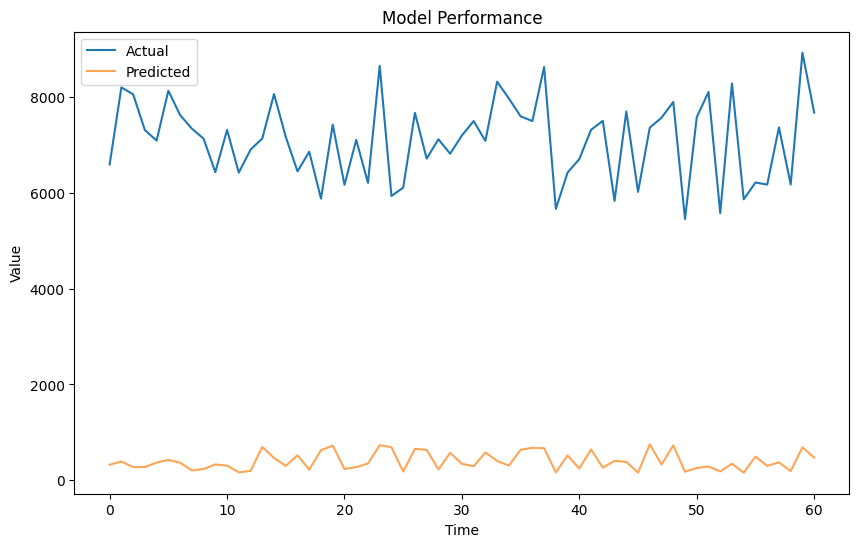

Simple RNN - MAE: 6706.804, R2 Score: -64.605

Evaluating GRU model...
2/2 [==============================] - 0s 11ms/step


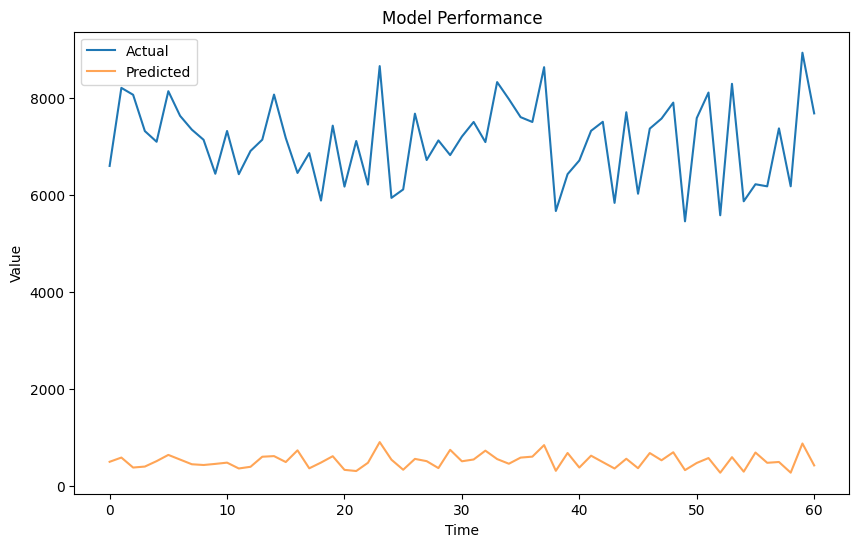

GRU - MAE: 6592.493, R2 Score: -62.354

                    MAE   R2 Score
LSTM        6714.470428 -64.688937
Simple RNN  6706.803651 -64.604734
GRU         6592.493248 -62.354101


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function to evaluate a model
def evaluate_model(model, X_test, y_test):
    # Making predictions
    y_pred = model.predict(X_test)

    # Calculating the metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'Model Performance')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return mae, r2

# Evaluate each model
models = {'LSTM': lstm_model, 'Simple RNN': rnn_model, 'GRU': gru_model}
results = {}

for model_name, model in models.items():
    print(f'Evaluating {model_name} model...')
    mae, r2 = evaluate_model(model, X_test, y_test)
    results[model_name] = {'MAE': mae, 'R2 Score': r2}
    print(f'{model_name} - MAE: {mae:.3f}, R2 Score: {r2:.3f}\n')

# Display results
results_df = pd.DataFrame(results).T
print(results_df)
